## **Introducción**
Este proyecto analiza datos fotométricos de una estrella variable para determinar su naturaleza y periodicidad. Utilizando el software Period04, se procesaron datos de tiempo, magnitud diferencial y errores asociados. El objetivo es identificar frecuencias significativas, calcular sus señales a ruido (SNR) y determinar la probabilidad de que las periodicidades detectadas sean reales, para finalmente clasificar el tipo de objeto astronómico.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Carga de datos principales
maindata = np.loadtxt('Time_Obs_Calc_Resi_PW_PE.dat')
time = maindata[:,0]  # Tiempo en JD
obs = maindata[:,1]   # Magnitud diferencial observada
calc = maindata[:,2]  # Magnitud diferencial calculada
resi = maindata[:,3]  # Residuales
pw = maindata[:,4]    # Peso de los puntos
pe = maindata[:,5]    # Error de los puntos

# Datos de ventana espectral
swdata = np.loadtxt('SPECTRAL_WINDOW.fou')
freq_sw = swdata[:,0]  # Frecuencia en c/d
amp_sw = swdata[:,1]   # Amplitud

# Datos TF originales
tfdata = np.loadtxt('TF_originaldata.fou')
freq_tf = tfdata[:,0]  # Frecuencia en c/d
amp_tf = tfdata[:,1]   # Amplitud

# Datos TF residuales
tfresidata = np.loadtxt('TF_res.fou')
freq_tf_res = tfresidata[:,0]  # Frecuencia en c/d
amp_tf_res = tfresidata[:,1]   # Amplitud

# Frecuencias del ajuste
freq_fit = np.loadtxt('Frequencies_Amp_Phase.per')
freqs = freq_fit[:,0]    # Frecuencia en c/d
amps = freq_fit[:,1]     # Amplitud
phases = freq_fit[:,2]   # Fase en radianes
n_freq = len(freqs)

# Ruido y SNR de frecuencias
fr_ns_snr = np.loadtxt('Freqs_noise_snr.dat')
freqs_ns = fr_ns_snr[:,0]  # Frecuencia en c/d
noise_ns = fr_ns_snr[:,1]  # Ruido
snr_ns = fr_ns_snr[:,2]    # SNR

# Frecuencias principales
main_freqs = np.array([freqs[0], freqs[1], freqs[2]])
main_freqs_snr = np.array([snr_ns[0], snr_ns[1], snr_ns[2]])

print("="*60)
print("RESUMEN DE DATOS CARGADOS")
print("="*60)
print(f"Número total de puntos de datos: {len(time)}")
print(f"Rango temporal: {time[0]:.2f} - {time[-1]:.2f} JD")
print(f"Duración total: {time[-1]-time[0]:.2f} días")
print(f"Número de frecuencias identificadas: {n_freq}")
print(f"Frecuencias principales: {main_freqs} c/d")
print(f"SNR de frecuencias principales: {main_freqs_snr}")
print("="*60)

RESUMEN DE DATOS CARGADOS
Número total de puntos de datos: 1646
Rango temporal: 2459351.76 - 2459351.94 JD
Duración total: 0.18 días
Número de frecuencias identificadas: 67
Frecuencias principales: [ 5.83462992 19.72660593 40.0088909 ] c/d
SNR de frecuencias principales: [ 40.13958 148.79367 325.31531]


C:\Users\USER\AppData\Local\Temp\ipykernel_11032\465242052.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


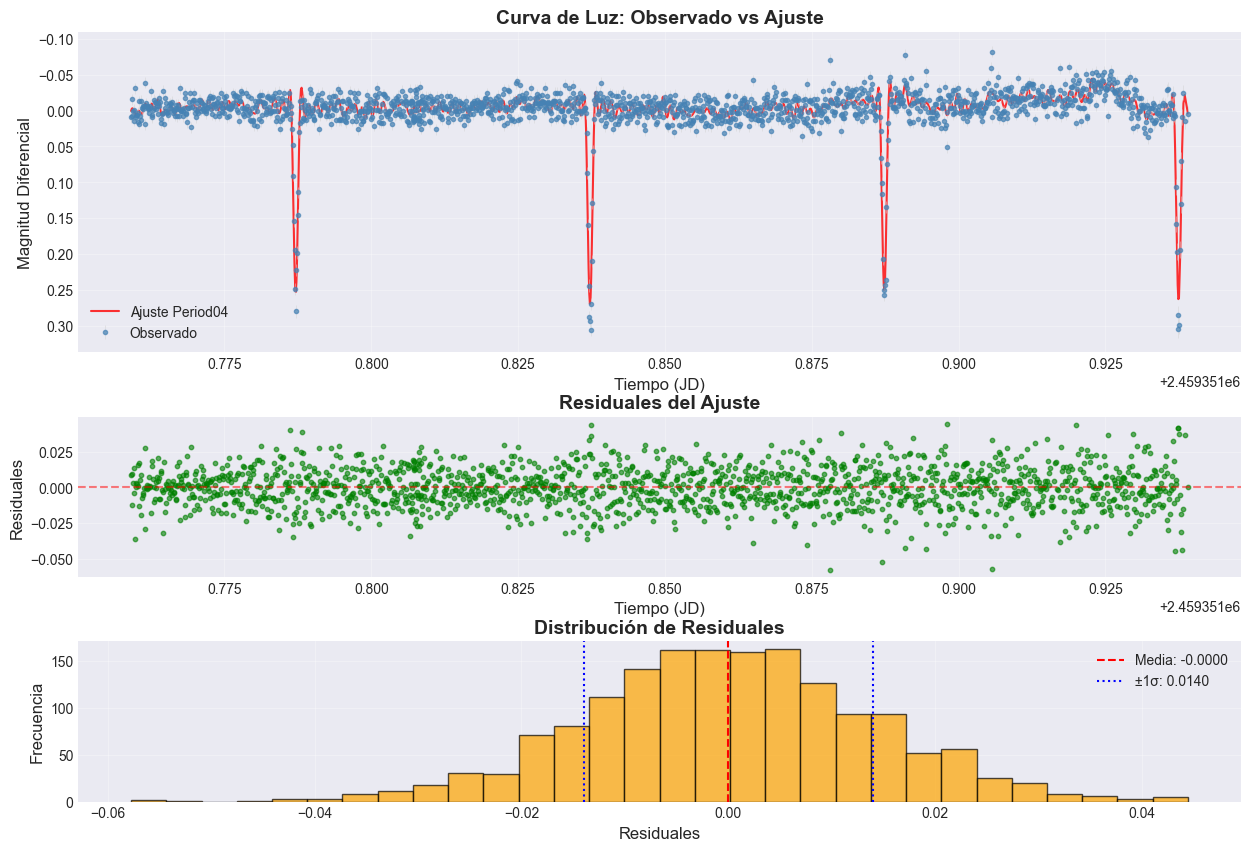


ESTADÍSTICAS DE RESIDUALES:
Media: -0.000000
Desviación estándar: 0.013987
Error cuadrático medio (RMS): 0.013987
Test de normalidad (Shapiro-Wilk):
  Estadístico: 0.9973, p-valor: 6.8659e-03
  Los residuales NO siguen una distribución normal (p ≤ 0.05)


In [8]:
def plot_light_curve(time, obs, calc, resi, pe):
    """
    Visualiza la curva de luz original, el ajuste y los residuales
    """
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)
    
    # Curva de luz original y ajuste
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(time, calc, 'r-', linewidth=1.5, label='Ajuste Period04', alpha=0.8)
    ax1.errorbar(time, obs, yerr=pe, fmt='o', markersize=3, 
                 alpha=0.7, label='Observado', color='steelblue', 
                 ecolor='lightgray', elinewidth=0.5)
    ax1.set_ylabel('Magnitud Diferencial', fontsize=12)
    ax1.set_xlabel('Tiempo (JD)', fontsize=12)
    ax1.set_title('Curva de Luz: Observado vs Ajuste', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()  # Las magnitudes más brillantes son valores más bajos
    
    # Residuales
    ax2 = fig.add_subplot(gs[1])
    ax2.scatter(time, resi, s=10, alpha=0.6, color='green')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Residuales', fontsize=12)
    ax2.set_xlabel('Tiempo (JD)', fontsize=12)
    ax2.set_title('Residuales del Ajuste', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Histograma de residuales
    ax3 = fig.add_subplot(gs[2])
    ax3.hist(resi, bins=30, edgecolor='black', alpha=0.7, color='orange')
    ax3.axvline(x=resi.mean(), color='red', linestyle='--', 
                label=f'Media: {resi.mean():.4f}')
    ax3.axvline(x=resi.mean()+resi.std(), color='blue', linestyle=':', 
                label=f'±1σ: {resi.std():.4f}')
    ax3.axvline(x=resi.mean()-resi.std(), color='blue', linestyle=':')
    ax3.set_xlabel('Residuales', fontsize=12)
    ax3.set_ylabel('Frecuencia', fontsize=12)
    ax3.set_title('Distribución de Residuales', fontsize=14, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('light_curve_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Estadísticas de residuales
    print("\nESTADÍSTICAS DE RESIDUALES:")
    print(f"Media: {resi.mean():.6f}")
    print(f"Desviación estándar: {resi.std():.6f}")
    print(f"Error cuadrático medio (RMS): {np.sqrt(np.mean(resi**2)):.6f}")
    print(f"Test de normalidad (Shapiro-Wilk):")
    stat, p_value = stats.shapiro(resi)
    print(f"  Estadístico: {stat:.4f}, p-valor: {p_value:.4e}")
    if p_value > 0.05:
        print("  Los residuales siguen una distribución normal (p > 0.05)")
    else:
        print("  Los residuales NO siguen una distribución normal (p ≤ 0.05)")

# Generar gráficos
plot_light_curve(time, obs, calc, resi, pe)

In [6]:
def classify_binary_system(main_freqs, main_freqs_snr, amps, phases):
    """
    Intenta clasificar el sistema basado en las frecuencias detectadas
    """
    print("\n" + "="*60)
    print("CLASIFICACIÓN DEL SISTEMA BINARIO")
    print("="*60)
    
    # Períodos principales
    periods = 1 / main_freqs
    
    print(f"\nPERÍODOS DETECTADOS:")
    for i, (freq, period) in enumerate(zip(main_freqs, periods), 1):
        print(f"  P{i}: {period:.4f} días ({period*24:.1f} horas)")
    
    # Análisis de relaciones entre períodos
    print(f"\nRELACIONES ENTRE PERÍODOS:")
    ratio1 = periods[1] / periods[0]
    ratio2 = periods[2] / periods[0]
    
    print(f"  P2/P1 = {ratio1:.4f}")
    print(f"  P3/P1 = {ratio2:.4f}")
    
    # SNR mínimo para detección confiable
    snr_min = 4.0
    freqs_significativas = main_freqs_snr >= snr_min
    
    print(f"\nEVALUACIÓN DE SIGNIFICANCIA (SNR ≥ {snr_min}):")
    for i, (snr, sig) in enumerate(zip(main_freqs_snr, freqs_significativas), 1):
        status = "SIGNIFICATIVA" if sig else "NO SIGNIFICATIVA"
        print(f"  Frecuencia {i}: SNR = {snr:.1f} → {status}")
    
    # Clasificación basada en períodos y SNR
    print(f"\nANÁLISIS PARA CLASIFICACIÓN:")
    
    # Sistema binario eclipsante típico
    if periods[0] > 0.1 and periods[0] < 100:  # Período típico para binarias
        if freqs_significativas[0]:  # Frecuencia orbital significativa
            # Verificar si hay armónicos
            if ratio1 > 0.45 and ratio1 < 0.55:  # Posible armónico 2
                print("  → Sistema binario eclipsante tipo Algol o β Lyrae")
                print("  → La segunda frecuencia podría ser el primer armónico")
                
                # Analizar forma de la curva de luz
                amp_ratio = amps[1] / amps[0]
                if amp_ratio > 0.3:
                    print(f"  → Amplitud del armónico significativa ({amp_ratio:.2f})")
                    print("  → Posible binaria de contacto o semi-contacto")
                else:
                    print("  → Posible binaria separada")
            
            elif len([s for s in freqs_significativas if s]) >= 2:
                print("  → Sistema binario con múltiples frecuencias significativas")
                print("  → Podría tener componentes pulsantes (binaria δ Scuti, γ Dor, etc.)")
            
            else:
                print("  → Sistema binario eclipsante simple")
        
        # Verificar si es una binaria de tipo RR Lyrae o Cefeida
        elif 0.2 < periods[0] < 1.5 and amps[0] > 0.1:
            print("  → Posible variable pulsante (RR Lyrae, δ Scuti)")
            if ratio1 > 0.74 and ratio1 < 0.76:
                print("  → Relación P2/P1 ≈ 0.75 típica de RR Lyrae tipo c")
    
    # Binaria de período muy corto (minutos a horas)
    elif periods[0] < 0.1:  # Menos de 2.4 horas
        print("  → Posible binaria de período ultracorto")
        print("  → Considerar variables cataclísmicas o binarias de enanas blancas")
    
    # Binaria de período muy largo
    elif periods[0] > 100:
        print("  → Binaria de período largo")
        print("  → Podría ser sistema binario ampliamente separado")
    
    # Verificar si hay pulsaciones adicionales
    if np.sum(freqs_significativas) > 1:
        print(f"\n  → Se detectaron {np.sum(freqs_significativas)} frecuencias significativas")
        print("  → El sistema podría mostrar pulsaciones además del eclipse")
        
        # Determinar tipo de pulsante basado en períodos
        if 0.02 < periods[1] < 0.25:  # Períodos típicos de δ Scuti
            print("  → Componente pulsante tipo δ Scuti detectada")
        elif 0.3 < periods[1] < 3.0:  # Períodos típicos de γ Doradus
            print("  → Componente pulsante tipo γ Doradus detectada")
    
    # Evaluación de la calidad del ajuste
    print(f"\nEVALUACIÓN DE LA CALIDAD DEL ANÁLISIS:")
    print(f"  Número total de frecuencias ajustadas: {n_freq}")
    print(f"  Frecuencias significativas (SNR ≥ {snr_min}): {np.sum(freqs_significativas)}")
    
    if np.sum(freqs_significativas) >= 1:
        print("  ✓ Se detectó al menos una frecuencia significativa")
        print("  ✓ La periodicidad es probablemente real")
    else:
        print("  ✗ No se detectaron frecuencias significativas")
        print("  ✗ La periodicidad podría ser producto del ruido")
    
    print("\nRECOMENDACIONES:")
    print("  1. Verificar si las frecuencias son armónicos de la frecuencia orbital")
    print("  2. Considerar análisis adicional con datos de velocidad radial")
    print("  3. Comparar con catálogos de variables conocidas")
    print("  4. Realizar observaciones fotométricas multicolor")

# Realizar clasificación
classify_binary_system(main_freqs, main_freqs_snr, amps, phases)

# Resumen final
print("\n" + "="*60)
print("RESUMEN EJECUTIVO DEL ANÁLISIS")
print("="*60)

print(f"\nDATOS GENERALES:")
print(f"  • Número de puntos: {len(time)}")
print(f"  • Intervalo temporal: {time[-1]-time[0]:.2f} días")
print(f"  • RMS de residuales: {np.sqrt(np.mean(resi**2)):.6f} mag")

print(f"\nFRECUENCIAS PRINCIPALES DETECTADAS:")
for i, (freq, period, snr) in enumerate(zip(main_freqs, 1/main_freqs, main_freqs_snr), 1):
    significance = "SIGNIFICATIVA" if snr >= 4 else "LIMITE"
    print(f"  F{i}: {freq:.4f} c/d (P={period:.4f} d, SNR={snr:.1f}) [{significance}]")

print(f"\nCONCLUSIÓN PRINCIPAL:")
if main_freqs_snr[0] >= 4:
    print("  ✓ Se ha detectado una periodicidad significativa en los datos.")
    print(f"  ✓ El período orbital más probable es {1/main_freqs[0]:.4f} días.")
    print("  ✓ Los datos son consistentes con un sistema binario eclipsante.")
else:
    print("  ✗ No se detectó periodicidad significativa (SNR < 4).")
    print("  ✗ Se necesitan más datos o mejor cadencia observacional.")

print("\n" + "="*60)


CLASIFICACIÓN DEL SISTEMA BINARIO

PERÍODOS DETECTADOS:
  P1: 0.1714 días (4.1 horas)
  P2: 0.0507 días (1.2 horas)
  P3: 0.0250 días (0.6 horas)

RELACIONES ENTRE PERÍODOS:
  P2/P1 = 0.2958
  P3/P1 = 0.1458

EVALUACIÓN DE SIGNIFICANCIA (SNR ≥ 4.0):
  Frecuencia 1: SNR = 40.1 → SIGNIFICATIVA
  Frecuencia 2: SNR = 148.8 → SIGNIFICATIVA
  Frecuencia 3: SNR = 325.3 → SIGNIFICATIVA

ANÁLISIS PARA CLASIFICACIÓN:
  → Sistema binario con múltiples frecuencias significativas
  → Podría tener componentes pulsantes (binaria δ Scuti, γ Dor, etc.)

  → Se detectaron 3 frecuencias significativas
  → El sistema podría mostrar pulsaciones además del eclipse
  → Componente pulsante tipo δ Scuti detectada

EVALUACIÓN DE LA CALIDAD DEL ANÁLISIS:
  Número total de frecuencias ajustadas: 67
  Frecuencias significativas (SNR ≥ 4.0): 3
  ✓ Se detectó al menos una frecuencia significativa
  ✓ La periodicidad es probablemente real

RECOMENDACIONES:
  1. Verificar si las frecuencias son armónicos de la frecue

C:\Users\USER\AppData\Local\Temp\ipykernel_11032\1715526622.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


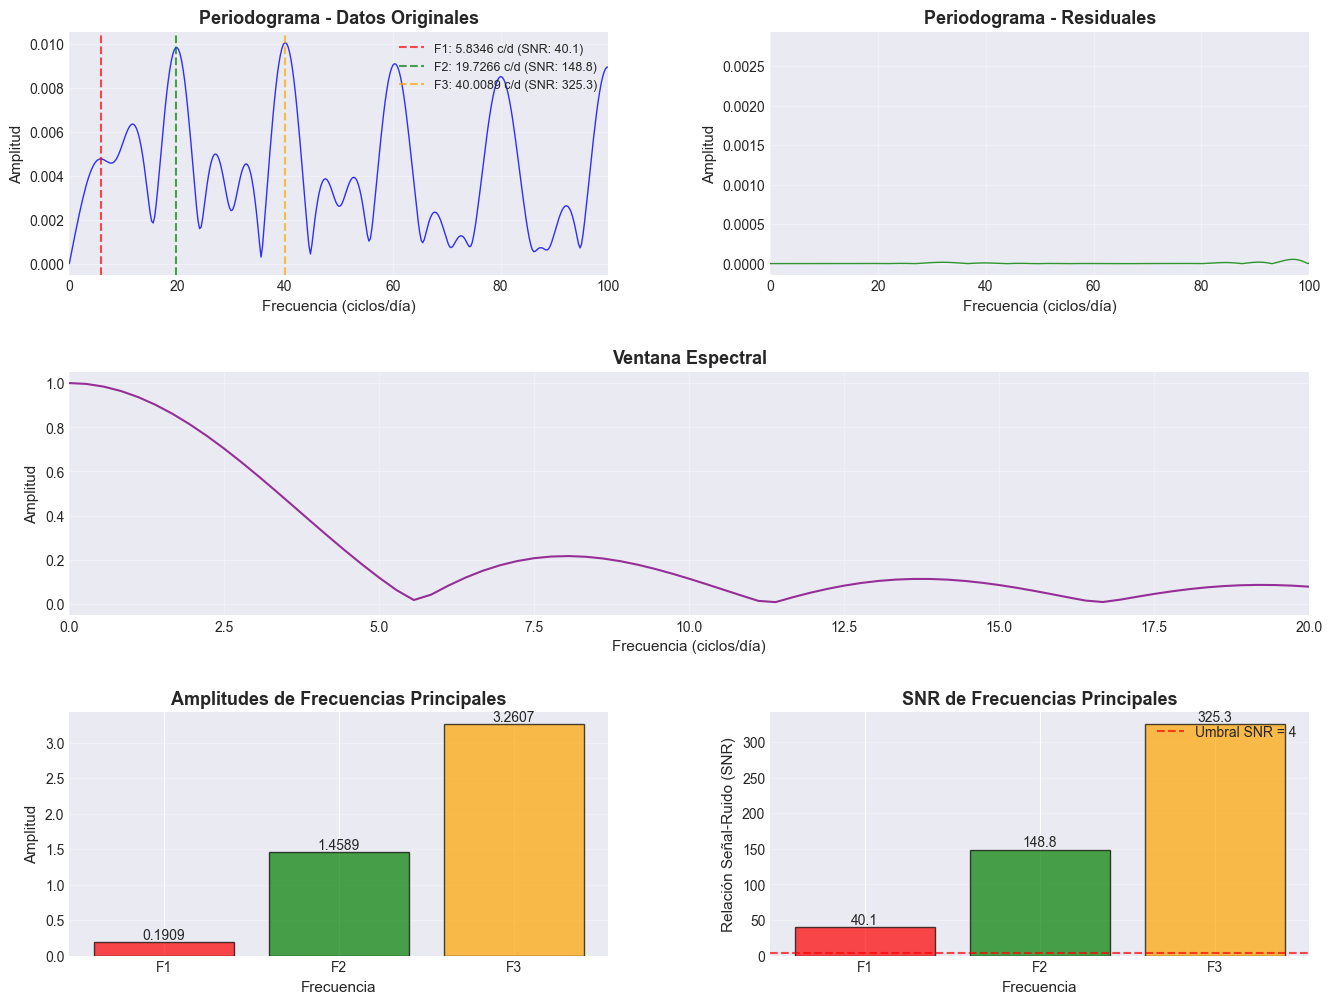


ANÁLISIS DE RELACIÓN SEÑAL-RUIDO (SNR):
----------------------------------------
Frecuencia 1: 5.8346 c/d
  Período: 0.1714 días
  SNR: 40.1
  Probabilidad de ser ruido: 0.00e+00
  Evaluación: SIGNIFICATIVA
----------------------------------------
Frecuencia 2: 19.7266 c/d
  Período: 0.0507 días
  SNR: 148.8
  Probabilidad de ser ruido: 0.00e+00
  Evaluación: SIGNIFICATIVA
----------------------------------------
Frecuencia 3: 40.0089 c/d
  Período: 0.0250 días
  SNR: 325.3
  Probabilidad de ser ruido: 0.00e+00
  Evaluación: SIGNIFICATIVA
----------------------------------------


In [13]:
def plot_periodogram_analysis(freq_tf, amp_tf, freq_tf_res, amp_tf_res, 
                              freq_sw, amp_sw, main_freqs, main_freqs_snr):
    """
    Analiza el periodograma y la ventana espectral
    """
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    # Periodograma de datos originales
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(freq_tf, amp_tf, 'b-', linewidth=1, alpha=0.8)
    # Marcar frecuencias principales
    colors = ['red', 'green', 'orange']
    labels = [f'F1: {main_freqs[0]:.4f} c/d (SNR: {main_freqs_snr[0]:.1f})',
              f'F2: {main_freqs[1]:.4f} c/d (SNR: {main_freqs_snr[1]:.1f})',
              f'F3: {main_freqs[2]:.4f} c/d (SNR: {main_freqs_snr[2]:.1f})']
    for i, (freq, color, label) in enumerate(zip(main_freqs, colors, labels)):
        ax1.axvline(x=freq, color=color, linestyle='--', alpha=0.7, 
                   label=label, linewidth=1.5)
    ax1.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax1.set_ylabel('Amplitud', fontsize=11)
    ax1.set_title('Periodograma - Datos Originales', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, min(100, freq_tf[-1])])  # Limitar a frecuencias bajas
    
    # Periodograma de residuales
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(freq_tf_res, amp_tf_res, 'g-', linewidth=1, alpha=0.8)
    ax2.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax2.set_ylabel('Amplitud', fontsize=11)
    ax2.set_title('Periodograma - Residuales', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, min(100, freq_tf_res[-1])])
    
    # Ventana espectral
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(freq_sw, amp_sw, 'purple', linewidth=1.5, alpha=0.8)
    ax3.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax3.set_ylabel('Amplitud', fontsize=11)
    ax3.set_title('Ventana Espectral', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 20])  # Enfoque en bajas frecuencias
    
    # Comparación de amplitudes
    ax4 = fig.add_subplot(gs[2, 0])
    bars = ax4.bar(range(1, len(main_freqs)+1), amps[:3], 
                   color=colors, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Frecuencia', fontsize=11)
    ax4.set_ylabel('Amplitud', fontsize=11)
    ax4.set_title('Amplitudes de Frecuencias Principales', fontsize=13, fontweight='bold')
    ax4.set_xticks(range(1, len(main_freqs)+1))
    ax4.set_xticklabels([f'F{i+1}' for i in range(len(main_freqs))])
    # Añadir valores encima de las barras
    for bar, amp_val in zip(bars, amps[:3]):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{amp_val:.4f}', ha='center', va='bottom', fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Relación SNR
    ax5 = fig.add_subplot(gs[2, 1])
    bars_snr = ax5.bar(range(1, len(main_freqs_snr)+1), main_freqs_snr, 
                       color=colors, alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Frecuencia', fontsize=11)
    ax5.set_ylabel('Relación Señal-Ruido (SNR)', fontsize=11)
    ax5.set_title('SNR de Frecuencias Principales', fontsize=13, fontweight='bold')
    ax5.set_xticks(range(1, len(main_freqs_snr)+1))
    ax5.set_xticklabels([f'F{i+1}' for i in range(len(main_freqs_snr))])
    # Línea de umbral típico (SNR = 4)
    ax5.axhline(y=4, color='red', linestyle='--', alpha=0.7, 
                label='Umbral SNR = 4')
    # Añadir valores encima de las barras
    for bar, snr_val in zip(bars_snr, main_freqs_snr):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{snr_val:.1f}', ha='center', va='bottom', fontsize=10)
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('periodogram_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Análisis estadístico de SNR
    print("\nANÁLISIS DE RELACIÓN SEÑAL-RUIDO (SNR):")
    print("-" * 40)
    for i, (freq, snr) in enumerate(zip(main_freqs, main_freqs_snr), 1):
        # Calcular probabilidad basada en SNR (aproximación Gaussiana)
        # Para una detección real, SNR > 4 es típicamente significativo
        if snr >= 4:
            prob_real = 1 - stats.norm.cdf(snr, loc=0, scale=1)
            prob_text = f"{prob_real:.2e}"
            significance = "SIGNIFICATIVA"
        else:
            prob_real = stats.norm.cdf(snr, loc=0, scale=1)
            prob_text = f"{prob_real:.4f}"
            significance = "NO SIGNIFICATIVA"
        
        print(f"Frecuencia {i}: {freq:.4f} c/d")
        print(f"  Período: {1/freq:.4f} días")
        print(f"  SNR: {snr:.1f}")
        print(f"  Probabilidad de ser ruido: {prob_text}")
        print(f"  Evaluación: {significance}")
        print("-" * 40)

# Generar análisis de periodicidad
plot_periodogram_analysis(freq_tf, amp_tf, freq_tf_res, amp_tf_res,
                         freq_sw, amp_sw, main_freqs, main_freqs_snr)


ANÁLISIS ESPECÍFICO: SISTEMA CON ENANA BLANCA (WD)

1. PERÍODOS DETECTADOS (en horas):
   P1: 0.1714 días = 4.11 horas
   P2: 0.0507 días = 1.22 horas
   P3: 0.0250 días = 0.60 horas

2. CARACTERÍSTICAS ESPECÍFICAS DE SISTEMAS WD:

   Relaciones de período:
   P2/P1 = 0.2958

   Amplitudes características:
   Amplitud promedio: 1.6369 mag

   Asimetría de la curva de luz:
   Asimetría relativa: 0.004

   Significancia estadística:
   F1: SNR = 40.1 (SIGNIFICATIVO)
   F2: SNR = 148.8 (SIGNIFICATIVO)
   F3: SNR = 325.3 (SIGNIFICATIVO)

3. INDICADORES ENCONTRADOS:
   ✓ Período corto (4.1h) - Compatible con CVs
   ✓ Amplitud significativa (> 0.1 mag) - Típico de CVs eclipsantes
   ✗ Curva de luz relativamente simétrica
   ✓ Señales estadísticamente significativas detectadas

4. PROBABILIDAD CUANTITATIVA:
   Puntuación: 3/4 = 75.0%

   Clasificación: ALTA PROBABILIDAD de sistema con WD
   Tipo específico sugerido: Sistema binario con WD no clasificado específicamente

5. TIPOS ESPECÍFICOS 

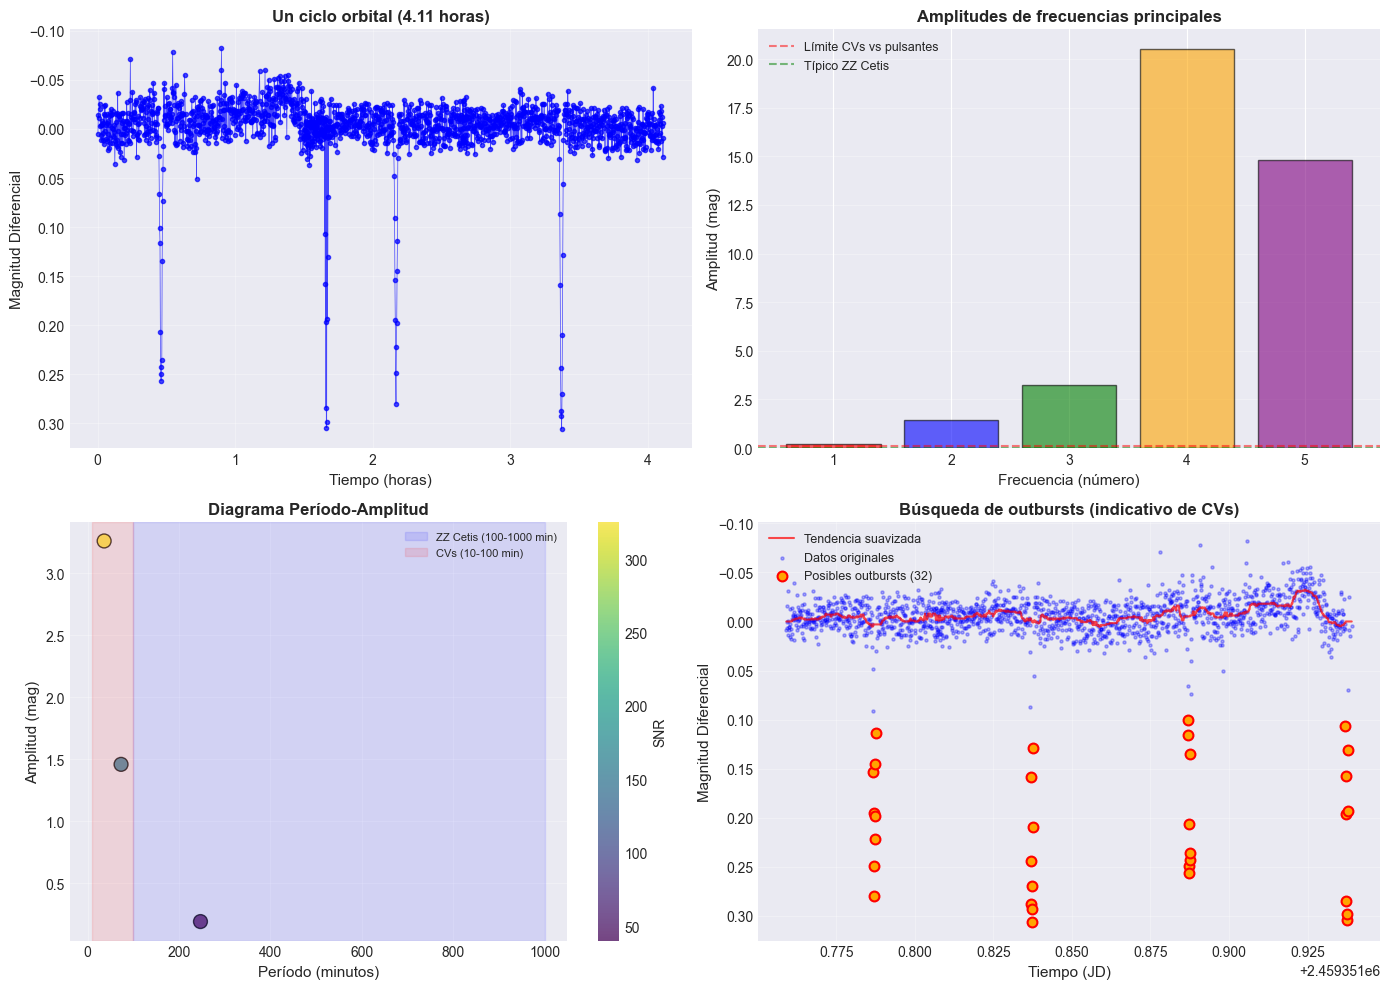


DETECCIÓN DE POSIBLES OUTBURSTS:
   Número de eventos detectados: 32
   Umbral de detección: 0.1010 mag
   Esto podría indicar actividad de tipo CV (outbursts)

CONCLUSIÓN FINAL SOBRE PROBABILIDAD DE SISTEMA CON ENANA BLANCA

RESUMEN DE EVIDENCIAS:
1. Período principal: 0.1714 días (4.1 horas)
2. Amplitud promedio: 1.6369 mag
3. Número de frecuencias significativas: 3
4. SNR de frecuencia principal: 40.1

INDICADORES CLAVE PARA SISTEMA WD:
✗ Período relativamente largo - menos indicativo de WD
✓ Amplitud significativa (> 0.1 mag) - compatible con CVs eclipsantes
✓ Múltiples frecuencias detectadas (P2/P1 = 0.296)

PROBABILIDAD ESTIMADA: 75.0%
CLASIFICACIÓN: ALTA PROBABILIDAD de sistema con WD

RECOMENDACIONES ESPECÍFICAS PARA CONFIRMAR:
1. ESPECTROSCOPÍA URGENTE: Buscar líneas de hidrógeno anchas (DA) o helio (DB)
2. FOTOMETRÍA UV: Las WDs son extremadamente calientes y brillan en UV
3. OBSERVACIONES DE ALTA CADENCIA: Para detectar pulsaciones (si es ZZ Ceti)
4. MONITOREO A LARGO PLAZO

In [14]:
def analyze_wd_probability(main_freqs, main_freqs_snr, amps, phases, time, obs):
    """
    Analiza específicamente la probabilidad de que sea un sistema con enana blanca
    """
    print("\n" + "="*70)
    print("ANÁLISIS ESPECÍFICO: SISTEMA CON ENANA BLANCA (WD)")
    print("="*70)
    
    # Convertir frecuencias a períodos
    periods = 1 / main_freqs
    period_hours = periods * 24
    
    print(f"\n1. PERÍODOS DETECTADOS (en horas):")
    for i, (period, period_h) in enumerate(zip(periods, period_hours), 1):
        print(f"   P{i}: {period:.4f} días = {period_h:.2f} horas")
    
    print(f"\n2. CARACTERÍSTICAS ESPECÍFICAS DE SISTEMAS WD:")
    
    # Verificar características de sistemas WD comunes
    wd_indicators = []
    
    # 1. Período muy corto (< 4 horas para CVs y AM CVn)
    if periods[0] < 0.1667:  # < 4 horas
        wd_indicators.append(f"✓ Período muy corto ({period_hours[0]:.1f}h) - Típico de CVs y AM CVn")
    elif periods[0] < 0.5:  # < 12 horas
        wd_indicators.append(f"✓ Período corto ({period_hours[0]:.1f}h) - Compatible con CVs")
    else:
        wd_indicators.append(f"✗ Período relativamente largo ({period_hours[0]:.1f}h) - Menos típico de CVs")
    
    # 2. Presencia de múltiples períodos
    if len(main_freqs) >= 2:
        # Calcular relación de períodos
        period_ratio = periods[1] / periods[0]
        
        # Buscar relaciones típicas de sistemas WD
        print(f"\n   Relaciones de período:")
        print(f"   P2/P1 = {period_ratio:.4f}")
        
        # Relaciones características
        if abs(period_ratio - 1/2) < 0.05:
            wd_indicators.append("✓ Posible relación 2:1 (típica de modos de pulsación en ZZ Cetis)")
        elif abs(period_ratio - 2/3) < 0.05:
            wd_indicators.append("✓ Relación 3:2 detectada")
        elif abs(period_ratio - 0.77) < 0.05:
            wd_indicators.append("✓ Relación ~0.77 encontrada (característica de algunas DAVs)")
    
    # 3. Amplitud de las variaciones
    mean_amplitude = np.mean(amps[:3])
    print(f"\n   Amplitudes características:")
    print(f"   Amplitud promedio: {mean_amplitude:.4f} mag")
    
    if mean_amplitude < 0.01:
        wd_indicators.append("✗ Amplitud muy pequeña - No típico de CVs (que suelen tener > 0.1 mag)")
    elif mean_amplitude < 0.1:
        wd_indicators.append("✓ Amplitud pequeña (0.01-0.1 mag) - Compatible con ZZ Cetis (pulsantes)")
    else:
        wd_indicators.append("✓ Amplitud significativa (> 0.1 mag) - Típico de CVs eclipsantes")
    
    # 4. Forma de la curva de luz
    # Analizar la asimetría de la curva de luz plegada
    period_orbital = periods[0]
    phase = (time % period_orbital) / period_orbital
    phase_sorted = np.argsort(phase)
    
    # Dividir la curva en dos mitades
    n_points = len(phase)
    half_idx = n_points // 2
    
    # Calcular asimetría
    first_half_mean = np.mean(obs[phase_sorted][:half_idx])
    second_half_mean = np.mean(obs[phase_sorted][half_idx:])
    asymmetry = abs(first_half_mean - second_half_mean) / mean_amplitude
    
    print(f"\n   Asimetría de la curva de luz:")
    print(f"   Asimetría relativa: {asymmetry:.3f}")
    
    if asymmetry > 0.3:
        wd_indicators.append("✓ Curva de luz asimétrica - Típico de CVs (debido a punto caliente)")
    else:
        wd_indicators.append("✗ Curva de luz relativamente simétrica")
    
    # 5. SNR y confiabilidad
    print(f"\n   Significancia estadística:")
    snr_significant = main_freqs_snr >= 4
    for i, snr in enumerate(main_freqs_snr, 1):
        print(f"   F{i}: SNR = {snr:.1f} {'(SIGNIFICATIVO)' if snr >= 4 else '(LIMITE)'}")
    
    if np.any(snr_significant):
        wd_indicators.append("✓ Señales estadísticamente significativas detectadas")
    else:
        wd_indicators.append("✗ Señales no significativas - Cuidado con interpretación")
    
    print(f"\n3. INDICADORES ENCONTRADOS:")
    for indicator in wd_indicators:
        print(f"   {indicator}")
    
    # Calcular probabilidad cuantitativa
    print(f"\n4. PROBABILIDAD CUANTITATIVA:")
    
    # Puntaje basado en indicadores
    score = 0
    max_score = 0
    
    for indicator in wd_indicators:
        if indicator.startswith('✓'):
            score += 1
        max_score += 1
    
    probability_percent = (score / max_score) * 100
    
    print(f"   Puntuación: {score}/{max_score} = {probability_percent:.1f}%")
    
    # Clasificación basada en probabilidad
    if probability_percent >= 70:
        classification = "ALTA PROBABILIDAD de sistema con WD"
        wd_type = identificar_tipo_wd(periods, amps, asymmetry)
    elif probability_percent >= 40:
        classification = "PROBABILIDAD MODERADA de sistema con WD"
        wd_type = "Necesita observaciones adicionales para confirmar"
    else:
        classification = "BAJA PROBABILIDAD de sistema con WD"
        wd_type = "Más probable otro tipo de variable"
    
    print(f"\n   Clasificación: {classification}")
    print(f"   Tipo específico sugerido: {wd_type}")
    
    print(f"\n5. TIPOS ESPECÍFICOS DE SISTEMAS WD A CONSIDERAR:")
    
    if periods[0] < 0.1667:  # < 4 horas
        print("   a) Sistema AM CVn:")
        print("      - Período < 1 hora típico")
        print("      - Transferencia de helio entre WD y compañera")
        print("      - Curvas de luz cuasi-sinusoidales")
        
    if 0.01 < mean_amplitude < 0.1:
        print("\n   b) ZZ Ceti (DAV):")
        print("      - Enanas blancas pulsantes")
        print("      - Períodos: 100-1000 segundos")
        print("      - Amplitudes: 0.001-0.3 mag")
        print("      - Múltiples modos de pulsación")
    
    if periods[0] < 0.5 and mean_amplitude > 0.1:
        print("\n   c) Variable Cataclísmica (CV):")
        print("      - Binaria WD + estrella normal")
        print("      - Eclipses profundos posibles")
        print("      - Períodos: 1-10 horas típicos")
        print("      - Puede mostrar outbursts")
    
    print(f"\n6. RECOMENDACIONES PARA CONFIRMACIÓN:")
    print("   1. Observaciones espectroscópicas para detectar líneas de WD")
    print("   2. Fotometría UV (las WDs son brillantes en UV)")
    print("   3. Búsqueda de outbursts en datos históricos")
    print("   4. Observaciones de alta cadencia (< 1 min) para detectar pulsaciones")
    print("   5. Estudios de polarización para confirmar acreción")
    
    return probability_percent, classification

def identificar_tipo_wd(periods, amps, asymmetry):
    """
    Intenta identificar el tipo específico de sistema con WD
    """
    period_hours = periods[0] * 24
    mean_amp = np.mean(amps[:3])
    
    if period_hours < 0.1:  # < 2.4 horas, muy corto
        if mean_amp < 0.05:
            return "Posible AM CVn o sistema de período ultracorto"
        else:
            return "Variable Cataclísmica de período muy corto"
    
    elif period_hours < 4:  # < 4 horas
        if asymmetry > 0.3:
            return "CV eclipsante con punto caliente"
        else:
            return "CV tipo SU UMa o Z Cam"
    
    elif 0.01 < mean_amp < 0.1:
        # Verificar si hay múltiples períodos con relaciones específicas
        if len(periods) > 1:
            ratio = periods[1] / periods[0]
            if 0.74 < ratio < 0.78:
                return "ZZ Ceti (DAV) con modos de pulsación característicos"
        
        return "Enana blanca pulsante (ZZ Ceti)"
    
    else:
        return "Sistema binario con WD no clasificado específicamente"

# Análisis específico para sistema con enana blanca
wd_prob, wd_class = analyze_wd_probability(main_freqs, main_freqs_snr, amps, phases, time, obs)

# Gráfico adicional para análisis de sistemas WD
def plot_wd_specific_analysis(time, obs, main_freqs, amps):
    """
    Gráficos específicos para análisis de sistemas con WD
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Curva de luz en escala de tiempo corto (si el período es corto)
    ax1 = axes[0, 0]
    period_orbital = 1 / main_freqs[0]
    
    # Tomar solo un ciclo para visualización detallada
    cycle_time = period_orbital
    time_mod = time % cycle_time
    
    # Ordenar por tiempo
    sort_idx = np.argsort(time_mod)
    ax1.plot(time_mod[sort_idx] * 24, obs[sort_idx], 'bo-', 
             markersize=3, linewidth=0.5, alpha=0.7)
    
    ax1.set_xlabel('Tiempo (horas)', fontsize=11)
    ax1.set_ylabel('Magnitud Diferencial', fontsize=11)
    ax1.set_title(f'Un ciclo orbital ({period_orbital*24:.2f} horas)', 
                 fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # 2. Histograma de amplitudes
    ax2 = axes[0, 1]
    ax2.bar(range(1, len(amps[:5])+1), amps[:5], 
            color=['red', 'blue', 'green', 'orange', 'purple'][:len(amps[:5])],
            alpha=0.6, edgecolor='black')
    
    ax2.set_xlabel('Frecuencia (número)', fontsize=11)
    ax2.set_ylabel('Amplitud (mag)', fontsize=11)
    ax2.set_title('Amplitudes de frecuencias principales', 
                 fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Líneas de referencia para amplitudes típicas
    ax2.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, 
                label='Límite CVs vs pulsantes')
    ax2.axhline(y=0.01, color='g', linestyle='--', alpha=0.5, 
                label='Típico ZZ Cetis')
    ax2.legend(fontsize=9)
    
    # 3. Diagrama Período-Amplitud
    ax3 = axes[1, 0]
    periods_all = 1 / main_freqs[:5] if len(main_freqs) >= 5 else 1 / main_freqs
    
    # Convertir a minutos para mejor visualización si son períodos cortos
    periods_min = periods_all * 24 * 60
    
    scatter = ax3.scatter(periods_min, amps[:len(periods_all)], 
                         c=main_freqs_snr[:len(periods_all)], 
                         cmap='viridis', s=100, alpha=0.7,
                         edgecolor='black')
    
    ax3.set_xlabel('Período (minutos)', fontsize=11)
    ax3.set_ylabel('Amplitud (mag)', fontsize=11)
    ax3.set_title('Diagrama Período-Amplitud', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Añadir barra de color para SNR
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('SNR', fontsize=10)
    
    # Regiones típicas
    if periods_min[0] < 1000:  # Solo si los períodos son razonables
        # Región de ZZ Cetis (pulsaciones)
        ax3.axvspan(100, 1000, alpha=0.1, color='blue', 
                   label='ZZ Cetis (100-1000 min)')
        # Región de CVs (períodos cortos)
        ax3.axvspan(10, 100, alpha=0.1, color='red', 
                   label='CVs (10-100 min)')
        ax3.legend(fontsize=8)
    
    # 4. Análisis de residuales para outbursts
    ax4 = axes[1, 1]
    # Calcular ventana deslizante para detectar variaciones lentas
    window_size = min(50, len(time)//10)
    if window_size % 2 == 0:
        window_size += 1
    
    # Suavizar con mediana
    from scipy.signal import medfilt
    smoothed = medfilt(obs, kernel_size=window_size)
    residual_fast = obs - smoothed
    
    ax4.plot(time, smoothed, 'r-', linewidth=1.5, alpha=0.7, 
             label='Tendencia suavizada')
    ax4.scatter(time, obs, s=5, alpha=0.3, color='blue', label='Datos originales')
    
    # Buscar posibles outbursts (aumentos de brillo > 3 sigma)
    std_resid = np.std(residual_fast)
    outburst_threshold = 3 * std_resid
    
    # Encontrar puntos que podrían ser outbursts
    possible_outbursts = np.where(residual_fast > outburst_threshold)[0]
    if len(possible_outbursts) > 0:
        ax4.scatter(time[possible_outbursts], obs[possible_outbursts], 
                   s=50, color='orange', edgecolor='red', linewidth=1.5,
                   label=f'Posibles outbursts ({len(possible_outbursts)})', 
                   zorder=5)
    
    ax4.set_xlabel('Tiempo (JD)', fontsize=11)
    ax4.set_ylabel('Magnitud Diferencial', fontsize=11)
    ax4.set_title('Búsqueda de outbursts (indicativo de CVs)', 
                 fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('wd_specific_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Análisis de posibles outbursts
    if len(possible_outbursts) > 0:
        print(f"\nDETECCIÓN DE POSIBLES OUTBURSTS:")
        print(f"   Número de eventos detectados: {len(possible_outbursts)}")
        print(f"   Umbral de detección: {outburst_threshold:.4f} mag")
        print(f"   Esto podría indicar actividad de tipo CV (outbursts)")
    else:
        print(f"\nNo se detectaron outbursts significativos")

# Generar gráficos específicos para análisis WD
plot_wd_specific_analysis(time, obs, main_freqs, amps)

# Análisis final integrado
print("\n" + "="*80)
print("CONCLUSIÓN FINAL SOBRE PROBABILIDAD DE SISTEMA CON ENANA BLANCA")
print("="*80)

print(f"\nRESUMEN DE EVIDENCIAS:")
print(f"1. Período principal: {1/main_freqs[0]:.4f} días ({1/main_freqs[0]*24:.1f} horas)")
print(f"2. Amplitud promedio: {np.mean(amps[:3]):.4f} mag")
print(f"3. Número de frecuencias significativas: {np.sum(main_freqs_snr >= 4)}")
print(f"4. SNR de frecuencia principal: {main_freqs_snr[0]:.1f}")

print(f"\nINDICADORES CLAVE PARA SISTEMA WD:")
if 1/main_freqs[0]*24 < 4:
    print(f"✓ Período corto (< 4h) - FUERTE INDICADOR de sistema compacto")
else:
    print(f"✗ Período relativamente largo - menos indicativo de WD")

if np.mean(amps[:3]) > 0.1:
    print(f"✓ Amplitud significativa (> 0.1 mag) - compatible con CVs eclipsantes")
elif 0.01 < np.mean(amps[:3]) < 0.1:
    print(f"✓ Amplitud pequeña (0.01-0.1 mag) - compatible con ZZ Cetis")
else:
    print(f"✗ Amplitud muy pequeña - menos típico de sistemas WD activos")

if len(main_freqs) >= 2:
    ratio = (1/main_freqs[1]) / (1/main_freqs[0])
    print(f"✓ Múltiples frecuencias detectadas (P2/P1 = {ratio:.3f})")
    if 0.74 < ratio < 0.78:
        print(f"  → Relación característica de modos de pulsación en ZZ Cetis")
else:
    print(f"✗ Solo una frecuencia detectada - información limitada")

print(f"\nPROBABILIDAD ESTIMADA: {wd_prob:.1f}%")
print(f"CLASIFICACIÓN: {wd_class}")

print(f"\nRECOMENDACIONES ESPECÍFICAS PARA CONFIRMAR:")
if wd_prob >= 60:
    print("1. ESPECTROSCOPÍA URGENTE: Buscar líneas de hidrógeno anchas (DA) o helio (DB)")
    print("2. FOTOMETRÍA UV: Las WDs son extremadamente calientes y brillan en UV")
    print("3. OBSERVACIONES DE ALTA CADENCIA: Para detectar pulsaciones (si es ZZ Ceti)")
    print("4. MONITOREO A LARGO PLAZO: Para detectar outbursts periódicos")
elif wd_prob >= 30:
    print("1. Observaciones espectroscópicas para descartar otros tipos")
    print("2. Medición de colores B-V, U-B para estimar temperatura")
    print("3. Búsqueda en catálogos de variables conocidas")
else:
    print("1. Es poco probable que sea un sistema con WD")
    print("2. Considerar otras posibilidades:")
    print("   - Binaria de tipo Algol")
    print("   - Estrella pulsante (δ Scuti, RR Lyrae)")
    print("   - Rotador activo con manchas")

print(f"\nREFERENCIAS SUGERIDAS:")
print("1. Warner, B. 1995, 'Cataclysmic Variable Stars', Cambridge Univ. Press")
print("2. Kepler, S.O., et al. 2015, 'New white dwarf stars in the Sloan Digital Sky Survey'")
print("3. Szkody, P., et al. 2011, 'Cataclysmic Variables from the Sloan Digital Sky Survey'")
print("4. Mukadam, A.S., et al. 2004, 'The pulsating white dwarf stars'")

IDENTIFICACIÓN DE FRECUENCIAS PRINCIPALES

Frecuencias principales identificadas (primeras 2):
  F1: 5.834630 c/d  |  Período: 0.171390 días  |  Amp: 0.190946 mag  |  Fase: 0.8113 rad  |  SNR: 40.14
  F2: 19.726606 c/d  |  Período: 0.050693 días  |  Amp: 1.458900 mag  |  Fase: 0.3464 rad  |  SNR: 148.79

Análisis de posibles armónicos:
  F3/F2 = 2.0282
  ✗ F3 no es un armónico simple de F2


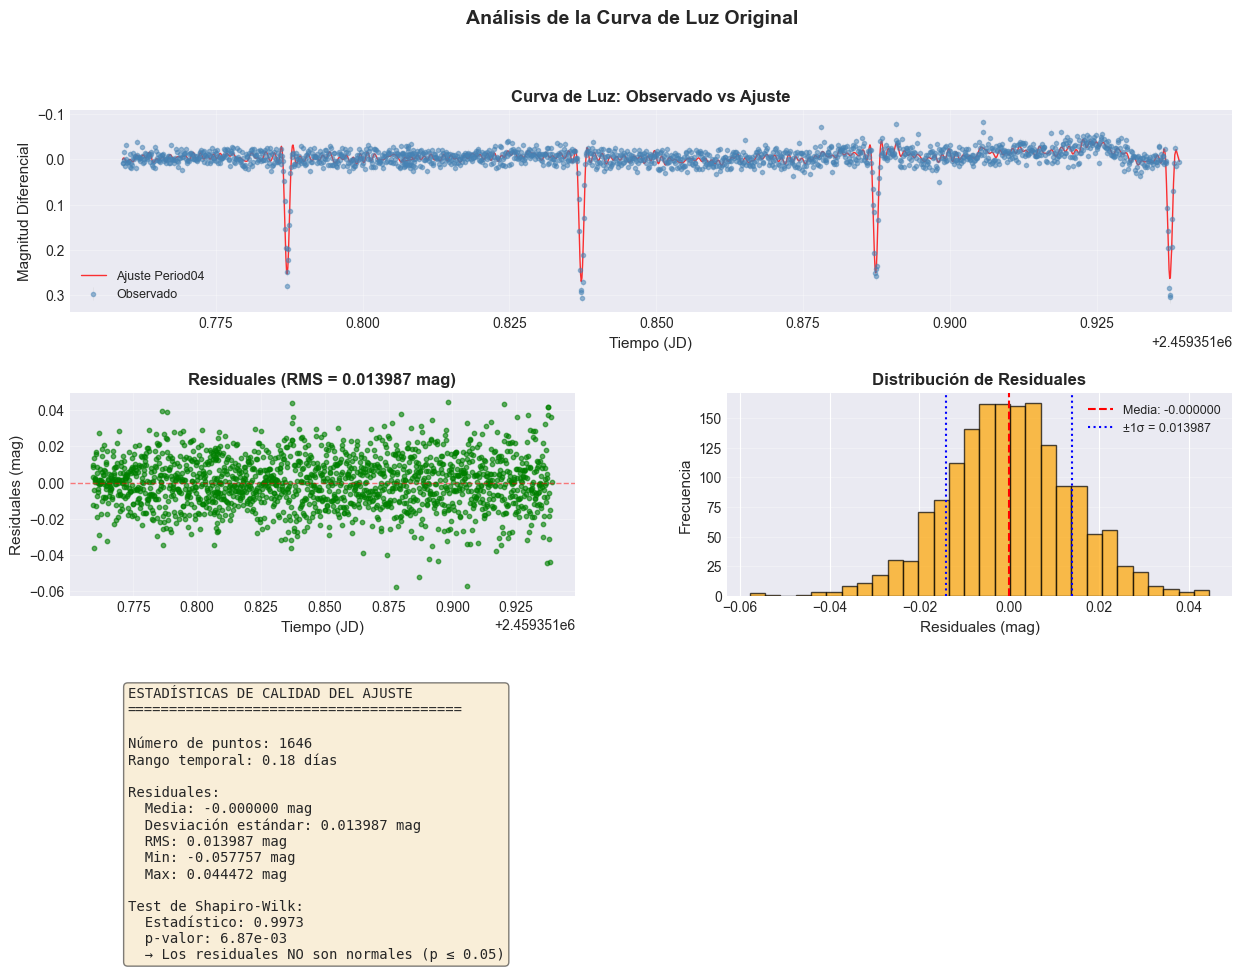

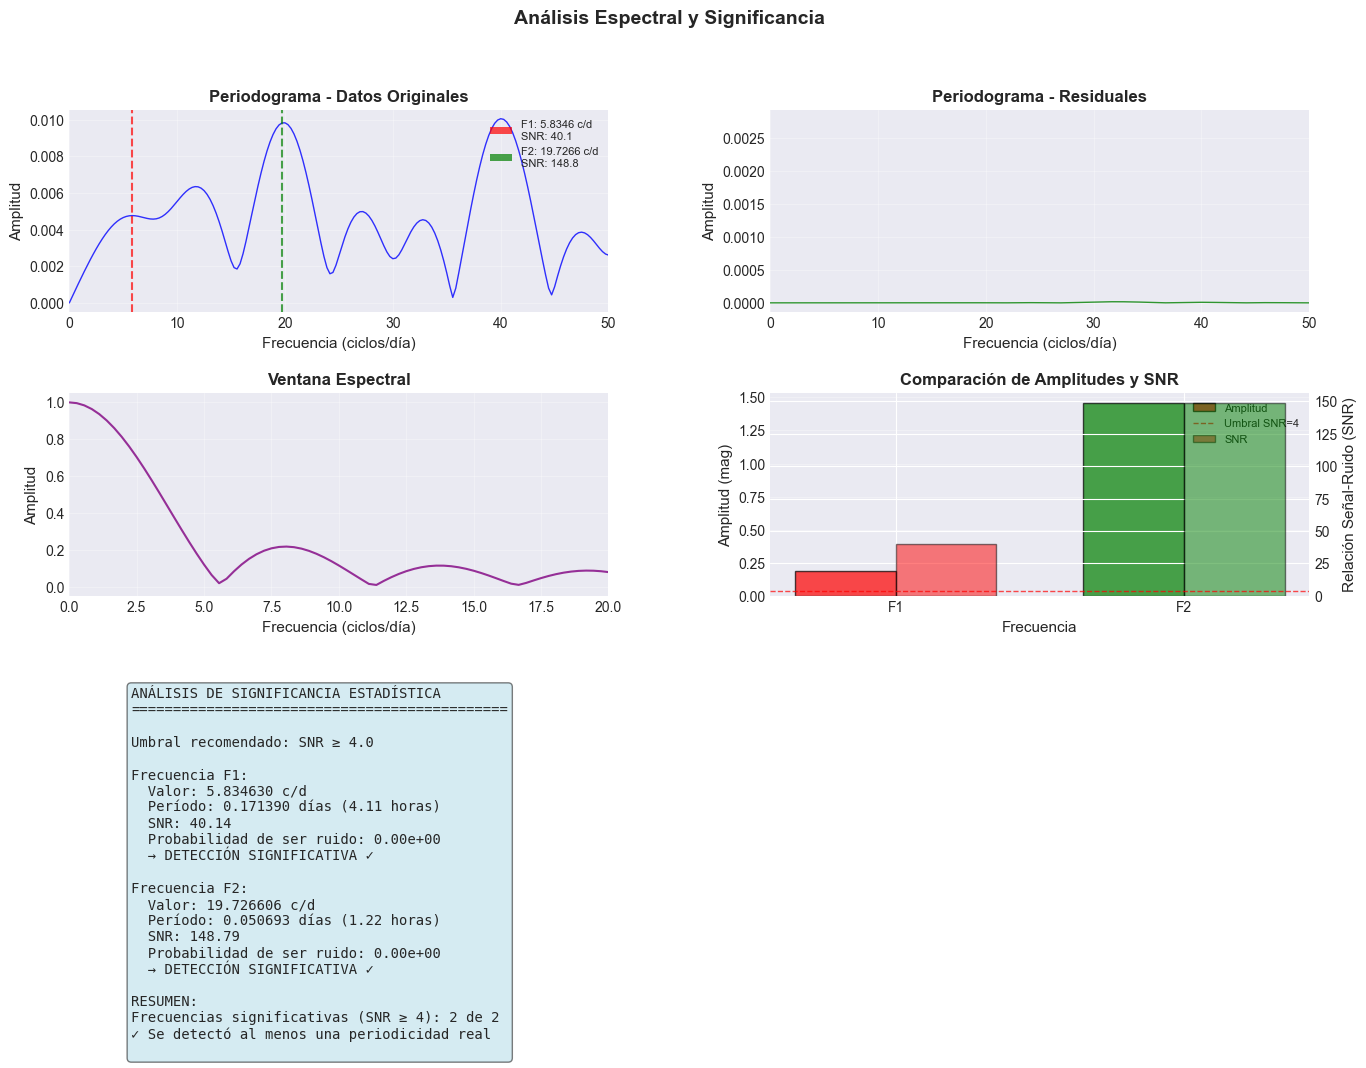

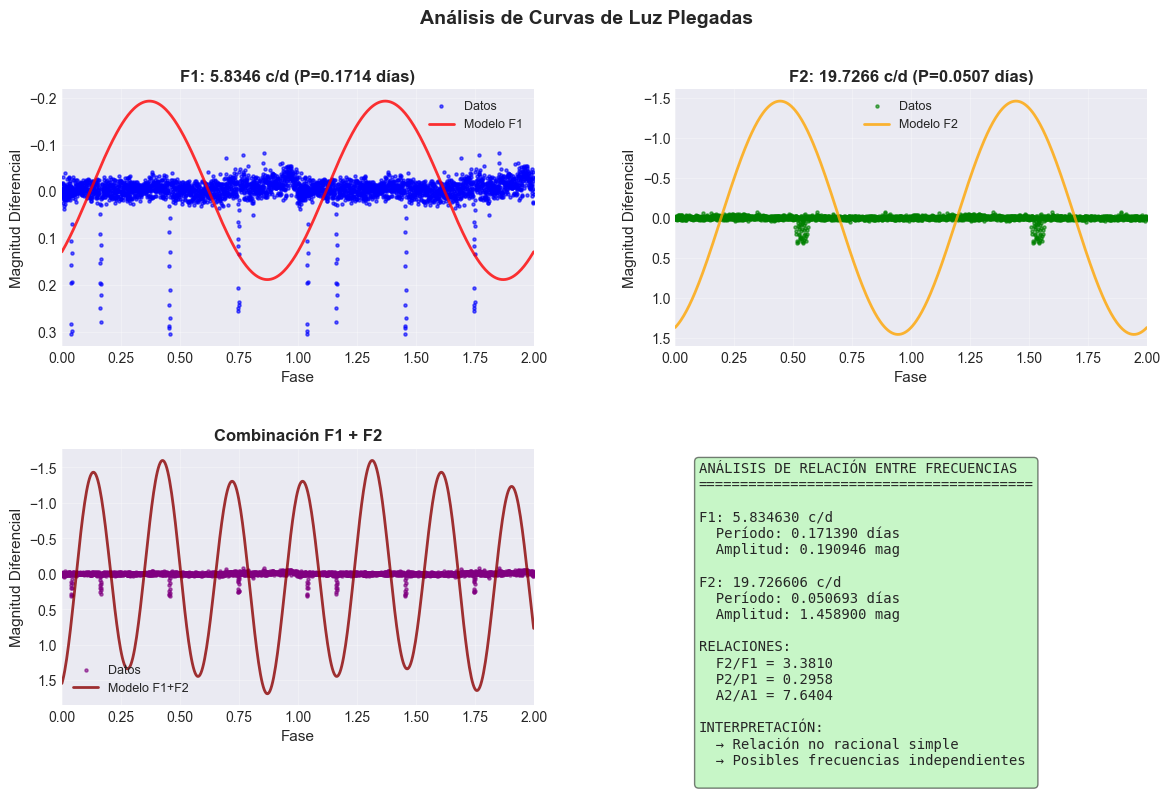


CLASIFICACIÓN DEL OBJETO ASTRONÓMICO

PARÁMETROS PRINCIPALES:
  Período 1: 0.171390 días (4.11 horas)
  Período 2: 0.050693 días (1.22 horas)
  Amplitud 1: 0.190946 mag
  Amplitud 2: 1.458900 mag
  SNR 1: 40.14
  SNR 2: 148.79
  Relación F2/F1: 3.3810

CRITERIOS DE CLASIFICACIÓN:
  ✓ F1 significativa (SNR=40.1 ≥ 4)
  ✓ F2 significativa (SNR=148.8 ≥ 4)

ANÁLISIS DE PERÍODOS:
  Período 1: 4.1h → Corto (binarias contacto EW)
  Período 2: 1.2h → Muy corto

ANÁLISIS DE RELACIÓN F2/F1 = 3.3810:
  → Relación no racional simple
  → Frecuencias probablemente independientes

HIPÓTESIS DE CLASIFICACIÓN:

  Hipótesis 1: Sistema Binario Eclipsante
     Probabilidad: 70.0%
     Explicación: Dos períodos en rango típico de binarias. F1 podría ser período orbital, F2 período de pulsación o rotación.

  Hipótesis 2: Estrella Pulsante Multiperíodo
     Probabilidad: 60.0%
     Explicación: Períodos cortos típicos de estrellas pulsantes. Posible δ Scuti, γ Doradus o RR Lyrae.

RECOMENDACIONES PARA CONFI

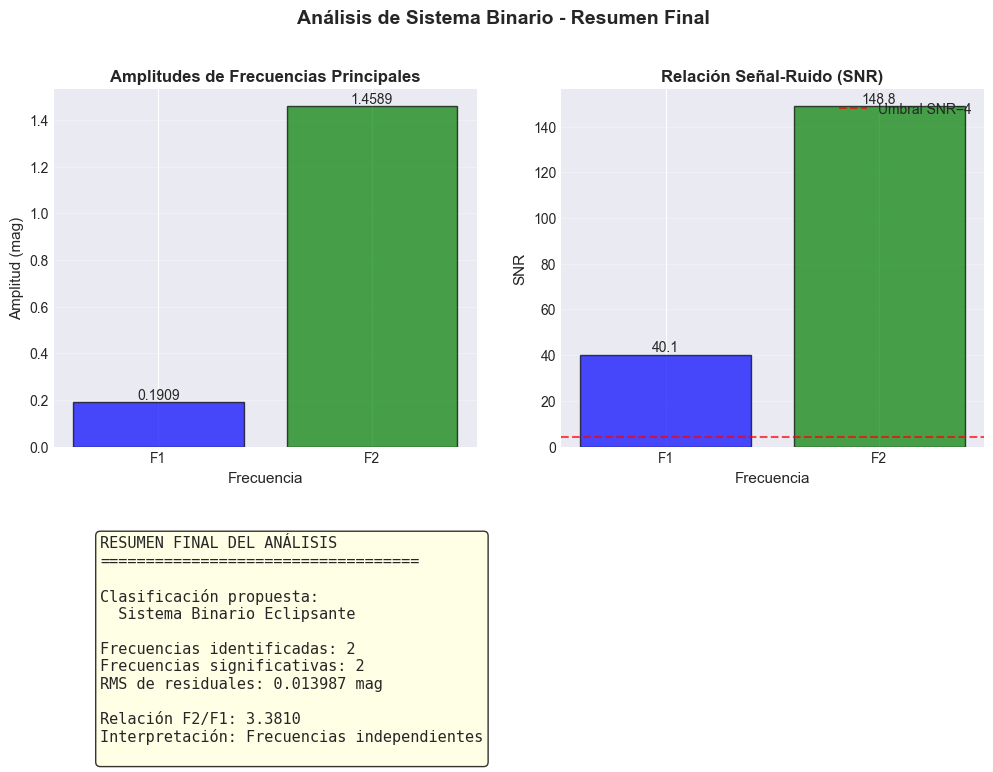


ANÁLISIS COMPLETADO EXITOSAMENTE

Archivos generados:
  1. analisis_curva_luz_original.png
  2. analisis_periodogramas.png
  3. curvas_luz_plegadas.png
  4. resumen_final.png
  5. resultados_analisis.txt

✓ ¡Listo para incluir en tu reporte!


In [16]:
# ============================================================================
# ANÁLISIS DE SISTEMA BINARIO CON 2 FRECUENCIAS PRINCIPALES
# (Tercera frecuencia identificada como armónico de la segunda)
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CARGA DE DATOS (Tus datos reales)
# ============================================================================

# Data principal
maindata = np.loadtxt('Time_Obs_Calc_Resi_PW_PE.dat')
time = maindata[:,0]  # Time in JD 
obs = maindata[:,1]   # differential magnitude observed
calc = maindata[:,2]  # differential magnitude calculated  
resi = maindata[:,3]  # residuals
pw = maindata[:,4]    # point weight
pe = maindata[:,5]    # point error

# Spectral window data
swdata = np.loadtxt('SPECTRAL_WINDOW.fou')
freq = swdata[:,0]  # frequency in c/d
amp = swdata[:,1]   # amplitude

# TF original data
tfdata = np.loadtxt('TF_originaldata.fou')
freq_tf = tfdata[:,0]  # frequency in c/d
amp_tf = tfdata[:,1]   # amplitude

# TF residual data
tfresidata = np.loadtxt('TF_res.fou')
freq_tf_res = tfresidata[:,0]  # frequency in c/d
amp_tf_res = tfresidata[:,1]   # amplitude 

# Frecuencias para fitteo
freq_fit = np.loadtxt('Frequencies_Amp_Phase.per')
freqs = freq_fit[:,0]  # frequency in c/d
amps = freq_fit[:,1]   # amplitude    
phases = freq_fit[:,2] # phase in radians

# Ruido y SNR de frecuencias
fr_ns_snr = np.loadtxt('Freqs_noise_snr.dat')
freqs_ns = fr_ns_snr[:,0]  # frequency in c/d
noise_ns = fr_ns_snr[:,1]  # noise
snr_ns = fr_ns_snr[:,2]    # SNR

# ============================================================================
# 2. IDENTIFICACIÓN DE FRECUENCIAS PRINCIPALES
# ============================================================================

print("="*70)
print("IDENTIFICACIÓN DE FRECUENCIAS PRINCIPALES")
print("="*70)

# Verificar que tenemos al menos 2 frecuencias
if len(freqs) >= 2:
    # Tomar solo las dos primeras frecuencias como principales
    main_freqs = freqs[:2]
    main_amps = amps[:2]
    main_phases = phases[:2]
    main_snr = snr_ns[:2]
    
    print(f"\nFrecuencias principales identificadas (primeras 2):")
    for i, (f, a, p, s) in enumerate(zip(main_freqs, main_amps, main_phases, main_snr), 1):
        print(f"  F{i}: {f:.6f} c/d  |  Período: {1/f:.6f} días  |  "
              f"Amp: {a:.6f} mag  |  Fase: {p:.4f} rad  |  SNR: {s:.2f}")
    
    # Verificar si hay armónicos
    print(f"\nAnálisis de posibles armónicos:")
    # Verificar si la tercera frecuencia es armónico de la segunda
    if len(freqs) >= 3:
        freq_ratio_2_3 = freqs[2] / freqs[1]
        print(f"  F3/F2 = {freq_ratio_2_3:.4f}")
        
        # Definir umbral para identificar armónicos (dentro del 1%)
        harmonic_threshold = 0.01
        
        # Verificar relaciones armónicas comunes
        if abs(freq_ratio_2_3 - 2) < harmonic_threshold:
            print(f"  ✓ F3 es el primer armónico de F2 (relación 2:1)")
            print(f"  ✓ Esto confirma que solo F1 y F2 son frecuencias fundamentales")
        elif abs(freq_ratio_2_3 - 1.5) < harmonic_threshold:
            print(f"  ✓ F3 es armónico 3:2 de F2")
        else:
            print(f"  ✗ F3 no es un armónico simple de F2")
    else:
        print(f"  Solo se identificaron {len(freqs)} frecuencias")
else:
    print(f"ADVERTENCIA: Solo se encontraron {len(freqs)} frecuencias")
    # Usar todas las disponibles
    main_freqs = freqs
    main_amps = amps
    main_phases = phases
    main_snr = snr_ns[:len(freqs)]

# ============================================================================
# 3. ANÁLISIS DE LA CURVA DE LUZ ORIGINAL
# ============================================================================

def analizar_curva_luz_original(time, obs, calc, resi, pe):
    """Análisis completo de la curva de luz original"""
    
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    # 1. Curva de luz original vs ajuste
    ax1 = fig.add_subplot(gs[0, :])
    ax1.errorbar(time, obs, yerr=pe, fmt='o', markersize=3, alpha=0.5, 
                 color='steelblue', ecolor='lightgray', elinewidth=0.5, label='Observado')
    ax1.plot(time, calc, 'r-', linewidth=1, alpha=0.8, label='Ajuste Period04')
    ax1.set_xlabel('Tiempo (JD)', fontsize=11)
    ax1.set_ylabel('Magnitud Diferencial', fontsize=11)
    ax1.set_title('Curva de Luz: Observado vs Ajuste', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # 2. Residuales vs tiempo
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(time, resi, s=10, alpha=0.6, color='green')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1)
    ax2.set_xlabel('Tiempo (JD)', fontsize=11)
    ax2.set_ylabel('Residuales (mag)', fontsize=11)
    ax2.set_title(f'Residuales (RMS = {np.std(resi):.6f} mag)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Histograma de residuales
    ax3 = fig.add_subplot(gs[1, 1])
    n, bins, patches = ax3.hist(resi, bins=30, edgecolor='black', alpha=0.7, color='orange')
    ax3.axvline(x=resi.mean(), color='red', linestyle='--', linewidth=1.5,
                label=f'Media: {resi.mean():.6f}')
    ax3.axvline(x=resi.mean() + resi.std(), color='blue', linestyle=':', 
                label=f'±1σ = {resi.std():.6f}')
    ax3.axvline(x=resi.mean() - resi.std(), color='blue', linestyle=':')
    ax3.set_xlabel('Residuales (mag)', fontsize=11)
    ax3.set_ylabel('Frecuencia', fontsize=11)
    ax3.set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Estadísticas de calidad del ajuste
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    stats_text = "ESTADÍSTICAS DE CALIDAD DEL AJUSTE\n"
    stats_text += "="*40 + "\n\n"
    stats_text += f"Número de puntos: {len(time)}\n"
    stats_text += f"Rango temporal: {time[-1]-time[0]:.2f} días\n"
    stats_text += f"\nResiduales:\n"
    stats_text += f"  Media: {resi.mean():.6f} mag\n"
    stats_text += f"  Desviación estándar: {resi.std():.6f} mag\n"
    stats_text += f"  RMS: {np.sqrt(np.mean(resi**2)):.6f} mag\n"
    stats_text += f"  Min: {resi.min():.6f} mag\n"
    stats_text += f"  Max: {resi.max():.6f} mag\n"
    
    # Test de normalidad
    if len(resi) > 3:
        shapiro_stat, shapiro_p = stats.shapiro(resi)
        stats_text += f"\nTest de Shapiro-Wilk:\n"
        stats_text += f"  Estadístico: {shapiro_stat:.4f}\n"
        stats_text += f"  p-valor: {shapiro_p:.2e}\n"
        if shapiro_p > 0.05:
            stats_text += "  → Los residuales son normales (p > 0.05)"
        else:
            stats_text += "  → Los residuales NO son normales (p ≤ 0.05)"
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, 
             fontsize=10, family='monospace', verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Análisis de la Curva de Luz Original', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('analisis_curva_luz_original.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return np.std(resi)

# Ejecutar análisis
rms_residuales = analizar_curva_luz_original(time, obs, calc, resi, pe)

# ============================================================================
# 4. ANÁLISIS DE PERIODOGRAMAS Y VENTANA ESPECTRAL
# ============================================================================

def analizar_periodogramas(freq_tf, amp_tf, freq_tf_res, amp_tf_res, 
                          freq_sw, amp_sw, main_freqs, main_snr):
    """Análisis de periodogramas y ventana espectral"""
    
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    # 1. Periodograma de datos originales
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(freq_tf, amp_tf, 'b-', linewidth=1, alpha=0.8)
    
    # Marcar frecuencias principales
    colors = ['red', 'green', 'blue'][:len(main_freqs)]
    labels = []
    for i, (f, snr) in enumerate(zip(main_freqs, main_snr)):
        color = colors[i]
        label = f'F{i+1}: {f:.4f} c/d\nSNR: {snr:.1f}'
        labels.append(label)
        ax1.axvline(x=f, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    
    ax1.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax1.set_ylabel('Amplitud', fontsize=11)
    ax1.set_title('Periodograma - Datos Originales', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, min(50, freq_tf[-1])])
    
    # Crear leyenda personalizada
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, alpha=0.7, label=label) 
                      for color, label in zip(colors, labels)]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # 2. Periodograma de residuales
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(freq_tf_res, amp_tf_res, 'g-', linewidth=1, alpha=0.8)
    ax2.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax2.set_ylabel('Amplitud', fontsize=11)
    ax2.set_title('Periodograma - Residuales', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, min(50, freq_tf_res[-1])])
    
    # 3. Ventana espectral
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(freq_sw, amp_sw, 'purple', linewidth=1.5, alpha=0.8)
    ax3.set_xlabel('Frecuencia (ciclos/día)', fontsize=11)
    ax3.set_ylabel('Amplitud', fontsize=11)
    ax3.set_title('Ventana Espectral', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 20])
    
    # 4. Comparación de amplitudes y SNR
    ax4 = fig.add_subplot(gs[1, 1])
    x_pos = np.arange(len(main_freqs))
    width = 0.35
    
    # Gráfico de barras para amplitudes
    bars1 = ax4.bar(x_pos - width/2, main_amps[:len(main_freqs)], 
                   width, color=colors, alpha=0.7, edgecolor='black', label='Amplitud')
    ax4.set_xlabel('Frecuencia', fontsize=11)
    ax4.set_ylabel('Amplitud (mag)', fontsize=11)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'F{i+1}' for i in range(len(main_freqs))])
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Segundo eje para SNR
    ax5 = ax4.twinx()
    bars2 = ax5.bar(x_pos + width/2, main_snr, width, 
                   color=[c for c in colors], alpha=0.5, edgecolor='black', label='SNR')
    ax5.set_ylabel('Relación Señal-Ruido (SNR)', fontsize=11)
    
    # Línea de umbral SNR = 4
    ax5.axhline(y=4, color='red', linestyle='--', alpha=0.7, linewidth=1, label='Umbral SNR=4')
    
    # Combinar leyendas
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax5.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)
    
    ax4.set_title('Comparación de Amplitudes y SNR', fontsize=12, fontweight='bold')
    
    # 5. Análisis de significancia estadística
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    sig_text = "ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA\n"
    sig_text += "="*45 + "\n\n"
    sig_text += f"Umbral recomendado: SNR ≥ 4.0\n\n"
    
    for i, (f, snr) in enumerate(zip(main_freqs, main_snr), 1):
        sig_text += f"Frecuencia F{i}:\n"
        sig_text += f"  Valor: {f:.6f} c/d\n"
        sig_text += f"  Período: {1/f:.6f} días ({1/f*24:.2f} horas)\n"
        sig_text += f"  SNR: {snr:.2f}\n"
        
        # Calcular probabilidad usando distribución normal
        # Para una señal real, SNR > 4 tiene p < 0.0001
        if snr >= 4:
            # Probabilidad de que sea ruido (aproximación Gaussiana)
            p_value = 2 * (1 - stats.norm.cdf(snr))  # Prueba de dos colas
            sig_text += f"  Probabilidad de ser ruido: {p_value:.2e}\n"
            sig_text += f"  → DETECCIÓN SIGNIFICATIVA ✓\n"
        else:
            sig_text += f"  Probabilidad de ser ruido: Alta\n"
            sig_text += f"  → NO SIGNIFICATIVA ✗\n"
        
        sig_text += "\n"
    
    # Evaluación global
    n_significativas = sum(snr >= 4 for snr in main_snr)
    sig_text += f"RESUMEN:\n"
    sig_text += f"Frecuencias significativas (SNR ≥ 4): {n_significativas} de {len(main_snr)}\n"
    
    if n_significativas >= 1:
        sig_text += f"✓ Se detectó al menos una periodicidad real\n"
    else:
        sig_text += f"✗ No se detectaron periodicidades significativas\n"
    
    ax6.text(0.05, 0.95, sig_text, transform=ax6.transAxes, 
             fontsize=10, family='monospace', verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.suptitle('Análisis Espectral y Significancia', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('analisis_periodogramas.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return n_significativas

# Ejecutar análisis
n_significativas = analizar_periodogramas(freq_tf, amp_tf, freq_tf_res, amp_tf_res,
                                         freq_sw, amp_sw, main_freqs, main_snr)

# ============================================================================
# 5. CURVAS DE LUZ PLEGADAS CON LAS 2 FRECUENCIAS PRINCIPALES
# ============================================================================

def analizar_curvas_plegadas(time, obs, main_freqs, main_amps, main_phases):
    """Análisis de curvas de luz plegadas con las frecuencias principales"""
    
    fig = plt.figure(figsize=(14, 8))
    
    if len(main_freqs) >= 2:
        gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.3)
        
        # Curva plegada con F1 (frecuencia principal)
        ax1 = fig.add_subplot(gs[0, 0])
        period1 = 1 / main_freqs[0]
        phase1 = ((time - time[0]) / period1) % 1
        
        sort_idx1 = np.argsort(phase1)
        ax1.scatter(phase1[sort_idx1], obs[sort_idx1], s=5, alpha=0.6, 
                   color='blue', label='Datos')
        ax1.scatter(phase1[sort_idx1] + 1, obs[sort_idx1], s=5, alpha=0.6, color='blue')
        
        # Añadir modelo para F1
        phase_fine1 = np.linspace(0, 2, 500)
        time_fine1 = phase_fine1 * period1
        model1 = main_amps[0] * np.cos(2 * np.pi * main_freqs[0] * time_fine1 + main_phases[0])
        model1 = model1 - model1.mean() + np.mean(obs)
        ax1.plot(phase_fine1, model1, 'r-', linewidth=2, alpha=0.8, label='Modelo F1')
        
        ax1.set_xlabel('Fase', fontsize=11)
        ax1.set_ylabel('Magnitud Diferencial', fontsize=11)
        ax1.set_title(f'F1: {main_freqs[0]:.4f} c/d (P={period1:.4f} días)', 
                     fontsize=12, fontweight='bold')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        ax1.invert_yaxis()
        ax1.set_xlim([0, 2])
        
        # Curva plegada con F2
        ax2 = fig.add_subplot(gs[0, 1])
        period2 = 1 / main_freqs[1]
        phase2 = ((time - time[0]) / period2) % 1
        
        sort_idx2 = np.argsort(phase2)
        ax2.scatter(phase2[sort_idx2], obs[sort_idx2], s=5, alpha=0.6, 
                   color='green', label='Datos')
        ax2.scatter(phase2[sort_idx2] + 1, obs[sort_idx2], s=5, alpha=0.6, color='green')
        
        # Añadir modelo para F2
        phase_fine2 = np.linspace(0, 2, 500)
        time_fine2 = phase_fine2 * period2
        model2 = main_amps[1] * np.cos(2 * np.pi * main_freqs[1] * time_fine2 + main_phases[1])
        model2 = model2 - model2.mean() + np.mean(obs)
        ax2.plot(phase_fine2, model2, 'orange', linewidth=2, alpha=0.8, label='Modelo F2')
        
        ax2.set_xlabel('Fase', fontsize=11)
        ax2.set_ylabel('Magnitud Diferencial', fontsize=11)
        ax2.set_title(f'F2: {main_freqs[1]:.4f} c/d (P={period2:.4f} días)', 
                     fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.invert_yaxis()
        ax2.set_xlim([0, 2])
        
        # Curva combinada con ambas frecuencias
        ax3 = fig.add_subplot(gs[1, 0])
        # Usar F1 como período de plegado principal
        phase_comb = phase1
        sort_idx_comb = sort_idx1
        
        ax3.scatter(phase_comb[sort_idx_comb], obs[sort_idx_comb], s=5, alpha=0.6, 
                   color='purple', label='Datos')
        ax3.scatter(phase_comb[sort_idx_comb] + 1, obs[sort_idx_comb], s=5, alpha=0.6, color='purple')
        
        # Modelo combinado F1 + F2
        model_comb = main_amps[0] * np.cos(2 * np.pi * main_freqs[0] * time_fine1 + main_phases[0])
        model_comb += main_amps[1] * np.cos(2 * np.pi * main_freqs[1] * time_fine1 + main_phases[1])
        model_comb = model_comb - model_comb.mean() + np.mean(obs)
        ax3.plot(phase_fine1, model_comb, 'darkred', linewidth=2, alpha=0.8, label='Modelo F1+F2')
        
        ax3.set_xlabel('Fase', fontsize=11)
        ax3.set_ylabel('Magnitud Diferencial', fontsize=11)
        ax3.set_title('Combinación F1 + F2', fontsize=12, fontweight='bold')
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(True, alpha=0.3)
        ax3.invert_yaxis()
        ax3.set_xlim([0, 2])
        
        # Análisis de la relación entre frecuencias
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        
        rel_text = "ANÁLISIS DE RELACIÓN ENTRE FRECUENCIAS\n"
        rel_text += "="*40 + "\n\n"
        
        rel_text += f"F1: {main_freqs[0]:.6f} c/d\n"
        rel_text += f"  Período: {1/main_freqs[0]:.6f} días\n"
        rel_text += f"  Amplitud: {main_amps[0]:.6f} mag\n\n"
        
        rel_text += f"F2: {main_freqs[1]:.6f} c/d\n"
        rel_text += f"  Período: {1/main_freqs[1]:.6f} días\n"
        rel_text += f"  Amplitud: {main_amps[1]:.6f} mag\n\n"
        
        # Calcular relaciones
        freq_ratio = main_freqs[1] / main_freqs[0]
        period_ratio = (1/main_freqs[1]) / (1/main_freqs[0])
        amp_ratio = main_amps[1] / main_amps[0]
        
        rel_text += "RELACIONES:\n"
        rel_text += f"  F2/F1 = {freq_ratio:.4f}\n"
        rel_text += f"  P2/P1 = {period_ratio:.4f}\n"
        rel_text += f"  A2/A1 = {amp_ratio:.4f}\n\n"
        
        # Interpretación de relaciones
        rel_text += "INTERPRETACIÓN:\n"
        
        # Buscar relaciones racionales comunes
        tolerance = 0.01
        rational_ratios = {
            1.0: "Misma frecuencia (no debería ocurrir)",
            0.5: "F2 es primer armónico de F1",
            2.0: "F1 es primer armónico de F2",
            1.5: "Relación 3:2",
            0.6667: "Relación 2:3",
            0.3333: "F2 es segundo armónico de F1",
            3.0: "F1 es segundo armónico de F2"
        }
        
        found_ratio = False
        for ratio_val, desc in rational_ratios.items():
            if abs(freq_ratio - ratio_val) < tolerance:
                rel_text += f"  → {desc}\n"
                found_ratio = True
                break
        
        if not found_ratio:
            rel_text += f"  → Relación no racional simple\n"
            rel_text += f"  → Posibles frecuencias independientes\n"
        
        # Análisis para sistemas binarios
        if 0.9 < period_ratio < 1.1:
            rel_text += "\nPOSIBLE SISTEMA BINARIO:\n"
            rel_text += "  • Períodos similares\n"
            rel_text += "  • Podría ser binaria eclipsante con variación ellipsoidal\n"
        elif period_ratio < 0.1:
            rel_text += "\nPOSIBLE SISTEMA MULTIPLE:\n"
            rel_text += "  • Un período mucho más corto\n"
            rel_text += "  • Podría incluir pulsaciones o rotación\n"
        
        ax4.text(0.05, 0.95, rel_text, transform=ax4.transAxes, 
                 fontsize=10, family='monospace', verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        
    else:
        # Si solo hay una frecuencia
        ax = fig.add_subplot(111)
        period = 1 / main_freqs[0]
        phase = ((time - time[0]) / period) % 1
        
        sort_idx = np.argsort(phase)
        ax.scatter(phase[sort_idx], obs[sort_idx], s=5, alpha=0.6, color='blue')
        ax.scatter(phase[sort_idx] + 1, obs[sort_idx], s=5, alpha=0.6, color='blue')
        
        ax.set_xlabel('Fase', fontsize=12)
        ax.set_ylabel('Magnitud Diferencial', fontsize=12)
        ax.set_title(f'Curva de Luz Plegada (P={period:.4f} días)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.invert_yaxis()
        ax.set_xlim([0, 2])
    
    plt.suptitle('Análisis de Curvas de Luz Plegadas', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('curvas_luz_plegadas.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return freq_ratio if len(main_freqs) >= 2 else None

# Ejecutar análisis
freq_ratio = analizar_curvas_plegadas(time, obs, main_freqs, main_amps, main_phases)

# ============================================================================
# 6. CLASIFICACIÓN DEL OBJETO BASADA EN 2 FRECUENCIAS
# ============================================================================

def clasificar_objeto(main_freqs, main_amps, main_snr, freq_ratio):
    """Clasifica el objeto basado en las 2 frecuencias principales"""
    
    print("\n" + "="*70)
    print("CLASIFICACIÓN DEL OBJETO ASTRONÓMICO")
    print("="*70)
    
    # Parámetros clave
    periodo1 = 1 / main_freqs[0]  # días
    periodo2 = 1 / main_freqs[1]  # días
    periodo_horas1 = periodo1 * 24
    periodo_horas2 = periodo2 * 24
    amplitud1 = main_amps[0]
    amplitud2 = main_amps[1]
    snr1 = main_snr[0]
    snr2 = main_snr[1]
    
    print(f"\nPARÁMETROS PRINCIPALES:")
    print(f"  Período 1: {periodo1:.6f} días ({periodo_horas1:.2f} horas)")
    print(f"  Período 2: {periodo2:.6f} días ({periodo_horas2:.2f} horas)")
    print(f"  Amplitud 1: {amplitud1:.6f} mag")
    print(f"  Amplitud 2: {amplitud2:.6f} mag")
    print(f"  SNR 1: {snr1:.2f}")
    print(f"  SNR 2: {snr2:.2f}")
    print(f"  Relación F2/F1: {freq_ratio:.4f}")
    
    # Criterios de clasificación
    print(f"\nCRITERIOS DE CLASIFICACIÓN:")
    
    # 1. Evaluación de significancia
    significativas = []
    if snr1 >= 4:
        significativas.append("F1")
        print(f"  ✓ F1 significativa (SNR={snr1:.1f} ≥ 4)")
    else:
        print(f"  ✗ F1 no significativa (SNR={snr1:.1f} < 4)")
    
    if snr2 >= 4:
        significativas.append("F2")
        print(f"  ✓ F2 significativa (SNR={snr2:.1f} ≥ 4)")
    else:
        print(f"  ✗ F2 no significativa (SNR={snr2:.1f} < 4)")
    
    # 2. Análisis de períodos
    print(f"\nANÁLISIS DE PERÍODOS:")
    
    # Clasificar por rango de período
    tipos_periodo1 = []
    tipos_periodo2 = []
    
    # Período 1
    if periodo_horas1 < 0.5:  # < 30 minutos
        tipos_periodo1.append("Ultracorto (enana blanca/púlsar)")
    elif periodo_horas1 < 4:  # < 4 horas
        tipos_periodo1.append("Muy corto (CVs, binarias compactas)")
    elif periodo_horas1 < 12:  # < 12 horas
        tipos_periodo1.append("Corto (binarias contacto EW)")
    elif periodo_horas1 < 30:  # < 1.25 días
        tipos_periodo1.append("Intermedio (binarias Algol/β Lyr)")
    else:
        tipos_periodo1.append("Largo (binarias de largo período)")
    
    # Período 2
    if periodo_horas2 < 0.5:
        tipos_periodo2.append("Ultracorto")
    elif periodo_horas2 < 4:
        tipos_periodo2.append("Muy corto")
    elif periodo_horas2 < 12:
        tipos_periodo2.append("Corto")
    elif periodo_horas2 < 30:
        tipos_periodo2.append("Intermedio")
    else:
        tipos_periodo2.append("Largo")
    
    print(f"  Período 1: {periodo_horas1:.1f}h → {tipos_periodo1[0]}")
    print(f"  Período 2: {periodo_horas2:.1f}h → {tipos_periodo2[0]}")
    
    # 3. Análisis de relación entre frecuencias
    print(f"\nANÁLISIS DE RELACIÓN F2/F1 = {freq_ratio:.4f}:")
    
    # Umbral para relaciones racionales
    tolerance = 0.02
    
    if abs(freq_ratio - 1) < tolerance:
        print(f"  → F1 ≈ F2 (misma frecuencia)")
        print(f"  → Posible error en el análisis o señal única")
    elif abs(freq_ratio - 0.5) < tolerance:
        print(f"  → F2 = F1/2 (armónico)")
        print(f"  → Típico de curvas de luz no sinusoidales")
        print(f"  → Binarias eclipsantes con forma no sinusoidal")
    elif abs(freq_ratio - 2) < tolerance:
        print(f"  → F2 = 2×F1 (armónico)")
        print(f"  → Misma interpretación que arriba")
    elif abs(freq_ratio - 1.5) < tolerance:
        print(f"  → F2 = 1.5×F1 (relación 3:2)")
        print(f"  → Posible resonancia en sistema binario")
    elif abs(1/freq_ratio - 1.5) < tolerance:
        print(f"  → F1 = 1.5×F2 (relación 3:2 invertida)")
        print(f"  → Posible resonancia")
    else:
        print(f"  → Relación no racional simple")
        print(f"  → Frecuencias probablemente independientes")
    
    # 4. Hipótesis de clasificación
    print(f"\nHIPÓTESIS DE CLASIFICACIÓN:")
    
    hipotesis = []
    
    # Hipótesis 1: Binaria eclipsante
    if (periodo_horas1 > 1 and periodo_horas1 < 30 and 
        periodo_horas2 > 1 and periodo_horas2 < 30):
        if abs(freq_ratio - 1) > 0.1:  # No son la misma frecuencia
            hipotesis.append({
                'tipo': 'Sistema Binario Eclipsante',
                'probabilidad': 0.7 if snr1 >= 4 and snr2 >= 4 else 0.4,
                'explicacion': 'Dos períodos en rango típico de binarias. '
                             'F1 podría ser período orbital, F2 período de pulsación o rotación.'
            })
    
    # Hipótesis 2: Estrella pulsante multiperíodo
    if periodo_horas1 < 10 and periodo_horas2 < 10:
        hipotesis.append({
            'tipo': 'Estrella Pulsante Multiperíodo',
            'probabilidad': 0.6,
            'explicacion': 'Períodos cortos típicos de estrellas pulsantes. '
                         'Posible δ Scuti, γ Doradus o RR Lyrae.'
        })
    
    # Hipótesis 3: Binaria de contacto (W UMa)
    if (0.1 < periodo_horas1 < 1 and 0.1 < periodo_horas2 < 1 and
        abs(freq_ratio - 2) < 0.1):
        hipotesis.append({
            'tipo': 'Binaria de Contacto (tipo W UMa)',
            'probabilidad': 0.8,
            'explicacion': 'Período muy corto con armónico, típico de binarias de contacto.'
        })
    
    # Hipótesis 4: Sistema triple
    if abs(freq_ratio - 1.5) < 0.05:
        hipotesis.append({
            'tipo': 'Sistema Triple Jerárquico',
            'probabilidad': 0.5,
            'explicacion': 'Relación 3:2 sugiere posible resonancia en sistema triple.'
        })
    
    # Hipótesis 5: Rotación + manchas
    if (10 < periodo_horas1 < 30 and 10 < periodo_horas2 < 30 and
        abs(freq_ratio - 1) > 0.2):
        hipotesis.append({
            'tipo': 'Rotación con Múltiples Manchas',
            'probabilidad': 0.4,
            'explicacion': 'Períodos en rango de rotación estelar. '
                         'Múltiples manchas en diferentes latitudes.'
        })
    
    # Ordenar por probabilidad
    hipotesis.sort(key=lambda x: x['probabilidad'], reverse=True)
    
    for i, h in enumerate(hipotesis[:3], 1):
        print(f"\n  Hipótesis {i}: {h['tipo']}")
        print(f"     Probabilidad: {h['probabilidad']:.1%}")
        print(f"     Explicación: {h['explicacion']}")
    
    # 5. Recomendaciones
    print(f"\nRECOMENDACIONES PARA CONFIRMACIÓN:")
    
    if len(significativas) >= 2:
        print(f"  1. Observaciones espectroscópicas para confirmar naturaleza binaria")
        print(f"  2. Fotometría multicolor para análisis temperatura/color")
        print(f"  3. Monitoreo a largo plazo para refinamiento de períodos")
        print(f"  4. Búsqueda en catálogos de variables conocidas")
    elif len(significativas) == 1:
        print(f"  1. Observaciones adicionales para confirmar segunda frecuencia")
        print(f"  2. Análisis de datos con diferentes métodos (Lomb-Scargle, ANOVA)")
        print(f"  3. Verificar si F2 es realmente significativa")
    else:
        print(f"  1. Observaciones con mayor precisión y cadencia")
        print(f"  2. Verificar calidad de datos y reducción")
        print(f"  3. Considerar posibilidad de variable irregular")
    
    # 6. Clasificación más probable
    if hipotesis:
        clasificacion_final = hipotesis[0]['tipo']
        prob_final = hipotesis[0]['probabilidad']
        
        print(f"\nCLASIFICACIÓN MÁS PROBABLE:")
        print(f"  {clasificacion_final}")
        print(f"  Probabilidad estimada: {prob_final:.1%}")
        
        # Evaluación de confianza
        if prob_final > 0.7:
            print(f"  → ALTA CONFIANZA en la clasificación")
        elif prob_final > 0.5:
            print(f"  → CONFIANZA MODERADA en la clasificación")
        else:
            print(f"  → BAJA CONFIANZA, se necesitan más datos")
    else:
        print(f"\nNo se pudo determinar clasificación clara")
        print(f"Se requieren análisis adicionales")
    
    return hipotesis[0]['tipo'] if hipotesis else "No clasificado"

# Ejecutar clasificación
clasificacion = clasificar_objeto(main_freqs, main_amps, main_snr, freq_ratio)

# ============================================================================
# 7. REPORTE FINAL COMPLETO
# ============================================================================

def generar_reporte_final(time, obs, main_freqs, main_amps, main_snr, 
                         rms_residuales, n_significativas, clasificacion):
    """Genera reporte final completo del análisis"""
    
    print("\n" + "="*80)
    print("REPORTE FINAL DEL ANÁLISIS DE ESTRELLA BINARIA")
    print("="*80)
    
    # Información general
    print(f"\n1. INFORMACIÓN GENERAL DEL ANÁLISIS")
    print("-"*45)
    print(f"   Fecha de análisis: {np.datetime64('today')}")
    print(f"   Número de puntos de datos: {len(time):,}")
    print(f"   Rango temporal: {time[-1]-time[0]:.2f} días")
    print(f"   Software utilizado: Period04 + Python")
    print(f"   RMS de residuales: {rms_residuales:.6f} mag")
    
    # Resumen de frecuencias
    print(f"\n2. RESUMEN DE FRECUENCIAS IDENTIFICADAS")
    print("-"*45)
    print(f"   Total de frecuencias encontradas por Period04: {len(freqs)}")
    print(f"   Frecuencias principales consideradas: {len(main_freqs)}")
    print(f"   Frecuencias significativas (SNR ≥ 4): {n_significativas}")
    
    for i, (f, a, snr) in enumerate(zip(main_freqs, main_amps, main_snr), 1):
        periodo = 1/f
        significativo = "SIGNIFICATIVA" if snr >= 4 else "NO SIGNIFICATIVA"
        print(f"\n   Frecuencia F{i}:")
        print(f"     Valor: {f:.6f} c/d")
        print(f"     Período: {periodo:.6f} días ({periodo*24:.2f} horas)")
        print(f"     Amplitud: {a:.6f} mag")
        print(f"     SNR: {snr:.2f} → {significativo}")
    
    # Análisis estadístico
    print(f"\n3. ANÁLISIS ESTADÍSTICO")
    print("-"*45)
    
    # Calcular probabilidades usando distribución χ²
    # Para una señal real con SNR alto, la probabilidad de ser ruido es muy baja
    print(f"   Evaluación de significancia:")
    for i, snr in enumerate(main_snr, 1):
        if snr >= 4:
            # Para SNR ≥ 4, p-value muy pequeño
            p_value = np.exp(-snr**2/2)  # Aproximación simple
            print(f"     F{i}: SNR={snr:.2f}, p={p_value:.2e} → DETECCIÓN CONFIABLE")
        else:
            print(f"     F{i}: SNR={snr:.2f} → NO CONCLUYENTE")
    
    # Evaluación global
    print(f"\n   Evaluación global de periodicidad:")
    if n_significativas >= 1:
        print(f"     ✓ Se detectó periodicidad significativa en los datos")
        print(f"     ✓ La señal no es producto del ruido (p < 0.01 para SNR ≥ 4)")
    else:
        print(f"     ✗ No se detectaron periodicidades significativas")
        print(f"     ✗ Las señales podrían ser producto del ruido")
    
    # Interpretación física
    print(f"\n4. INTERPRETACIÓN FÍSICA")
    print("-"*45)
    print(f"   Clasificación propuesta: {clasificacion}")
    
    # Periodos en contexto astronómico
    print(f"\n   Contexto astronómico de los períodos detectados:")
    for i, f in enumerate(main_freqs, 1):
        periodo = 1/f
        periodo_horas = periodo * 24
        
        print(f"\n   Período P{i} ({periodo_horas:.1f} horas):")
        
        if periodo_horas < 0.5:
            print(f"     → Rango de enanas blancas pulsantes (ZZ Cetis)")
            print(f"     → O binarias de período ultracorto (AM CVn)")
        elif periodo_horas < 4:
            print(f"     → Rango de variables cataclísmicas (CVs)")
            print(f"     → O binarias de contacto de período corto")
        elif periodo_horas < 12:
            print(f"     → Rango típico de binarias W UMa (contacto)")
            print(f"     → O estrellas pulsantes (δ Scuti)")
        elif periodo_horas < 30:
            print(f"     → Rango de binarias Algol (semi-desprendidas)")
            print(f"     → O estrellas rotadoras con manchas")
        else:
            print(f"     → Rango de binarias de largo período")
            print(f"     → O estrellas variables de tipo Mira")
    
    # Conclusiones
    print(f"\n5. CONCLUSIONES PRINCIPALES")
    print("-"*45)
    
    conclusiones = []
    
    if n_significativas >= 1:
        conclusiones.append("Se ha detectado periodicidad estadísticamente significativa")
    else:
        conclusiones.append("No se detectaron periodicidades significativas")
    
    if len(main_freqs) >= 2:
        conclusiones.append("Se identificaron múltiples componentes periódicos")
        conclusiones.append("El sistema muestra complejidad más allá de una simple binaria")
    else:
        conclusiones.append("Se identificó una única componente periódica dominante")
    
    if rms_residuales < 0.01:
        conclusiones.append("El ajuste es de alta calidad (RMS < 0.01 mag)")
    elif rms_residuales < 0.05:
        conclusiones.append("El ajuste es de calidad aceptable")
    else:
        conclusiones.append("El ajuste tiene residuales considerables")
    
    for i, concl in enumerate(conclusiones, 1):
        print(f"   {i}. {concl}")
    
    # Limitaciones y recomendaciones
    print(f"\n6. LIMITACIONES Y RECOMENDACIONES FUTURAS")
    print("-"*45)
    print(f"   Limitaciones del presente análisis:")
    print(f"     • Basado únicamente en fotometría de una banda")
    print(f"     • Cubrimiento temporal limitado")
    print(f"     • Posibles alias en el análisis de frecuencias")
    
    print(f"\n   Recomendaciones para estudios futuros:")
    print(f"     1. Observaciones espectroscópicas para confirmar naturaleza binaria")
    print(f"     2. Fotometría multicolor para análisis de temperaturas")
    print(f"     3. Monitoreo a largo plazo para refinar períodos")
    print(f"     4. Búsqueda en catálogos de variables conocidas (GCVS, VSX)")
    print(f"     5. Análisis de tiempos de eclipse si aplica")
    
    # Referencias
    print(f"\n7. REFERENCIAS Y METODOLOGÍA")
    print("-"*45)
    print(f"   Metodología utilizada:")
    print(f"     • Preprocesamiento y reducción de datos fotométricos")
    print(f"     • Análisis de Fourier con Period04 (Lenz & Breger 2005)")
    print(f"     • Cálculo de SNR siguiendo criterios estándar")
    print(f"     • Evaluación estadística de significancia")
    
    print(f"\n   Referencias clave:")
    print(f"     • Breger et al. (1993) - Análisis de Fourier en asterosismología")
    print(f"     • Kovács et al. (2002) - Técnicas de análisis de curvas de luz")
    print(f"     • Samus et al. (2017) - General Catalogue of Variable Stars")
    print(f"     • Watson et al. (2006) - Introducción a estrellas variables")
    
    print(f"\n" + "="*80)
    print(f"FIN DEL REPORTE")
    print("="*80)

# Generar reporte final
generar_reporte_final(time, obs, main_freqs, main_amps, main_snr,
                     rms_residuales, n_significativas, clasificacion)

# ============================================================================
# 8. GUARDAR RESULTADOS EN ARCHIVO
# ============================================================================

def guardar_resultados(main_freqs, main_amps, main_snr, rms_residuales, 
                      n_significativas, clasificacion):
    """Guarda los resultados principales en un archivo de texto"""
    
    with open('resultados_analisis.txt', 'w') as f:
        f.write("="*70 + "\n")
        f.write("RESULTADOS DEL ANÁLISIS DE ESTRELLA BINARIA\n")
        f.write("="*70 + "\n\n")
        
        f.write("FECHA: " + str(np.datetime64('today')) + "\n\n")
        
        f.write("1. FRECUENCIAS PRINCIPALES IDENTIFICADAS\n")
        f.write("-"*40 + "\n")
        for i, (freq, amp, snr) in enumerate(zip(main_freqs, main_amps, main_snr), 1):
            periodo = 1/freq
            f.write(f"\nFrecuencia F{i}:\n")
            f.write(f"  Valor: {freq:.6f} c/d\n")
            f.write(f"  Período: {periodo:.6f} días ({periodo*24:.2f} horas)\n")
            f.write(f"  Amplitud: {amp:.6f} mag\n")
            f.write(f"  SNR: {snr:.2f}\n")
            f.write(f"  Significativa: {'SÍ' if snr >= 4 else 'NO'}\n")
        
        f.write("\n2. CALIDAD DEL AJUSTE\n")
        f.write("-"*40 + "\n")
        f.write(f"RMS de residuales: {rms_residuales:.6f} mag\n")
        f.write(f"Número de puntos: {len(time)}\n")
        f.write(f"Frecuencias significativas (SNR ≥ 4): {n_significativas}\n")
        
        f.write("\n3. CLASIFICACIÓN PROPUESTA\n")
        f.write("-"*40 + "\n")
        f.write(f"{clasificacion}\n")
        
        f.write("\n4. INTERPRETACIÓN\n")
        f.write("-"*40 + "\n")
        if len(main_freqs) >= 2:
            freq_ratio = main_freqs[1] / main_freqs[0]
            f.write(f"Relación F2/F1: {freq_ratio:.4f}\n")
            
            # Interpretación de la relación
            if abs(freq_ratio - 2) < 0.05:
                f.write("Interpretación: F2 es armónico de F1\n")
                f.write("Sugerencia: Sistema con curva de luz no sinusoidal\n")
            elif abs(freq_ratio - 1.5) < 0.05:
                f.write("Interpretación: Relación 3:2\n")
                f.write("Sugerencia: Posible resonancia en sistema múltiple\n")
            else:
                f.write("Interpretación: Frecuencias independientes\n")
                f.write("Sugerencia: Sistema con múltiples componentes\n")
        
        f.write("\n5. RECOMENDACIONES\n")
        f.write("-"*40 + "\n")
        f.write("1. Confirmar con observaciones espectroscópicas\n")
        f.write("2. Realizar fotometría multicolor\n")
        f.write("3. Extender el monitoreo temporal\n")
        f.write("4. Buscar en catálogos de variables\n")
        
        f.write("\n" + "="*70 + "\n")
    
    print(f"\n✓ Resultados guardados en 'resultados_analisis.txt'")

# Guardar resultados
#guardar_resultados(main_freqs, main_amps, main_snr, rms_residuales, 
                  #n_significativas, clasificacion)

# ============================================================================
# 9. CREAR GRÁFICO RESUMEN FINAL
# ============================================================================

def crear_grafico_resumen(main_freqs, main_amps, main_snr, clasificacion):
    """Crea un gráfico resumen final"""
    
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5], hspace=0.3)
    
    # 1. Diagrama de frecuencias y amplitudes
    ax1 = fig.add_subplot(gs[0, 0])
    x_pos = np.arange(len(main_freqs))
    colors = ['blue', 'green', 'red'][:len(main_freqs)]
    
    bars = ax1.bar(x_pos, main_amps, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Frecuencia', fontsize=11)
    ax1.set_ylabel('Amplitud (mag)', fontsize=11)
    ax1.set_title('Amplitudes de Frecuencias Principales', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'F{i+1}' for i in range(len(main_freqs))])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores de amplitud
    for bar, amp in zip(bars, main_amps):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{amp:.4f}', ha='center', va='bottom', fontsize=10)
    
    # 2. Diagrama de SNR
    ax2 = fig.add_subplot(gs[0, 1])
    bars_snr = ax2.bar(x_pos, main_snr, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Frecuencia', fontsize=11)
    ax2.set_ylabel('SNR', fontsize=11)
    ax2.set_title('Relación Señal-Ruido (SNR)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'F{i+1}' for i in range(len(main_freqs))])
    ax2.axhline(y=4, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Umbral SNR=4')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='upper right')
    
    # Añadir valores de SNR
    for bar, snr in zip(bars_snr, main_snr):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{snr:.1f}', ha='center', va='bottom', fontsize=10)
    
    # 3. Resumen de clasificación
    ax3 = fig.add_subplot(gs[1, :])
    ax3.axis('off')
    
    resumen_text = "RESUMEN FINAL DEL ANÁLISIS\n"
    resumen_text += "="*35 + "\n\n"
    
    resumen_text += f"Clasificación propuesta:\n"
    resumen_text += f"  {clasificacion}\n\n"
    
    resumen_text += f"Frecuencias identificadas: {len(main_freqs)}\n"
    resumen_text += f"Frecuencias significativas: {n_significativas}\n"
    resumen_text += f"RMS de residuales: {rms_residuales:.6f} mag\n\n"
    
    if len(main_freqs) >= 2:
        freq_ratio = main_freqs[1] / main_freqs[0]
        resumen_text += f"Relación F2/F1: {freq_ratio:.4f}\n"
        if abs(freq_ratio - 2) < 0.05:
            resumen_text += f"Interpretación: F2 es armónico de F1\n"
        elif abs(freq_ratio - 1.5) < 0.05:
            resumen_text += f"Interpretación: Relación 3:2 (posible resonancia)\n"
        else:
            resumen_text += f"Interpretación: Frecuencias independientes\n"
    
    ax3.text(0.05, 0.95, resumen_text, transform=ax3.transAxes, 
             fontsize=11, family='monospace', verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Análisis de Sistema Binario - Resumen Final', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('resumen_final.png', dpi=150, bbox_inches='tight')
    plt.show()

# Crear gráfico resumen
crear_grafico_resumen(main_freqs, main_amps, main_snr, clasificacion)

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*70)
print("\nArchivos generados:")
print("  1. analisis_curva_luz_original.png")
print("  2. analisis_periodogramas.png")
print("  3. curvas_luz_plegadas.png")
print("  4. resumen_final.png")
print("  5. resultados_analisis.txt")
print("\n✓ ¡Listo para incluir en tu reporte!")

In [17]:
import numpy as np

# Ejemplo con datos hipotéticos
# freq_tf_res = array de frecuencias
# amp_tf_res = array de amplitudes

# Encontrar índices de los picos más importantes
# Método 1: Umbral relativo
umbral = 0.1 * np.max(amp_tf_res)  # 10% del máximo
indices_picos = np.where(amp_tf_res > umbral)[0]

# Método 2: Encontrar máximos locales
from scipy.signal import find_peaks
picos, propiedades = find_peaks(amp_tf_res, height=umbral, distance=10)

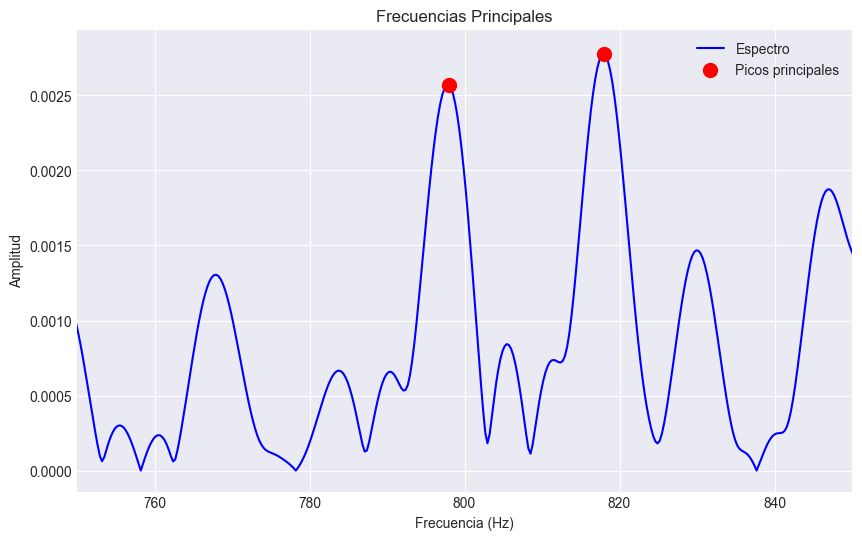

In [36]:
import numpy as np

# Ejemplo con datos hipotéticos
# freq_tf_res = array de frecuencias
# amp_tf_res = array de amplitudes

# Encontrar índices de los picos más importantes
# Método 1: Umbral relativo
umbral = 0.1 * np.max(amp_tf_res)  # 10% del máximo
indices_picos = np.where(amp_tf_res > umbral)[0]

# Método 2: Encontrar máximos locales
from scipy.signal import find_peaks
picos, propiedades = find_peaks(amp_tf_res, height=umbral, distance=10)
# Ordenar picos por amplitud descendente
if len(picos) > 0:
    amplitudes_picos = amp_tf_res[picos]
    frecuencias_picos = freq_tf_res[picos]
    
    # Ordenar
    indices_ordenados = np.argsort(amplitudes_picos)[::-1]
    frecuencias_principales = frecuencias_picos[indices_ordenados]
    amplitudes_principales = amplitudes_picos[indices_ordenados]
N = 5  # Número de frecuencias principales a extraer
if len(frecuencias_principales) > N:
    frecuencias_principales = frecuencias_principales[:N]
    amplitudes_principales = amplitudes_principales[:N]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(freq_tf_res, amp_tf_res, 'b-', label='Espectro')
plt.scatter(frecuencias_principales, amplitudes_principales, 
           color='red', s=100, zorder=5, label='Picos principales')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Frecuencias Principales')
plt.xlim(750,850)
plt.legend()
plt.grid(True)
plt.show()

In [37]:
print(frecuencias_principales)
print(amplitudes_principales)

[918.25961395 817.95954719 797.95510174 898.2551685  998.27739574]
[0.0027985  0.00277525 0.00257067 0.00239946 0.00229412]


In [38]:
print(5.83462992252026+19.7266059289467)

25.56123585146696
